#Import

In [ ]:
import pandas as pd

# Load data and add match IDs
points_df = pd.read_csv("Tennis Events Clean.csv")
points_df['match_id'] = range(1, len(points_df) + 1)

# Reorder columns to put match_id first
cols = points_df.columns.tolist()
points_df = points_df[['match_id'] + [col for col in cols if col != 'match_id']]

#Dataset preparation

##Parse point by point json

In [ ]:
import json
import re
import pandas as pd
import numpy as np


def convert_score_to_number(score):
    score = score.strip()
    score_map = {'A': 50, '40': 40, '30': 30, '15': 15, '0': 0}
    return score_map.get(score, int(score) if score.isdigit() else 0)


def parse_fifteens_content(fifteens_str):
    fifteens_clean = re.sub(r'\s*\|B\d+\|\s*', '', fifteens_str)
    return [p.strip() for p in fifteens_clean.split(',') if p.strip()]


def calculate_server_points_won(points, server):
    server_points_won = 0

    for i, point in enumerate(points):
        if i == 0:
            prev_home, prev_away = 0, 0
        else:
            prev_scores = points[i-1].split(':')
            prev_home = convert_score_to_number(prev_scores[0])
            prev_away = convert_score_to_number(prev_scores[1])

        curr_scores = point.split(':')
        curr_home = convert_score_to_number(curr_scores[0])
        curr_away = convert_score_to_number(curr_scores[1])

        if server == 1 and curr_home > prev_home:
            server_points_won += 1
        elif server == 2 and curr_away > prev_away:
            server_points_won += 1

    return server_points_won


def parse_tennis_json(json_data):
    if isinstance(json_data, str):
        data = json.loads(json_data)
    else:
        data = json_data

    results = {}

    for set_data in data['DATA']:
        set_name = set_data['TAB_NAME']
        set_number = int(set_name.split()[-1])
        games = []

        regular_games = []
        tiebreak_data = None

        for item in set_data['ITEMS']:
            if 'FIFTEENS_CONTENT' in item:
                regular_games.append(item)
            elif 'AWAY_RESULT_TI' in item:
                tiebreak_data = item

        for idx, game in enumerate(regular_games):
            game_num = idx + 1

            if game_num > 12 and 'TIEBREAK_BALL' not in game:
                continue

            points = parse_fifteens_content(game['FIFTEENS_CONTENT'])
            server_won_points = calculate_server_points_won(points, game['SERVING'])

            game_info = {
                'game_num': game_num,
                'serving': game.get('SERVING', 0),
                'server_lost': 'LOST_SERVE' in game,
                'away_score': int(game['AWAY_RESULT']),
                'home_score': int(game['HOME_RESULT']),
                'last_scored': game['LAST_SCORED'],
                'fifteens': game.get('FIFTEENS_CONTENT', ''),
                'is_tiebreak': False,
                'points': points,
                'total_points': len(points),
                'server_won_points': server_won_points
            }
            games.append(game_info)

        # Add tiebreak if exists
        if tiebreak_data and len([g for g in games if g['game_num'] <= 12]) == 12:
            tb_away = int(tiebreak_data['AWAY_RESULT_TI'])
            tb_home = int(tiebreak_data['HOME_RESULT_TI'])

            tiebreak_game_info = {
                'game_num': 13,
                'serving': 0,
                'server_lost': False,
                'away_score': int(tiebreak_data['AWAY_RESULT']),
                'home_score': int(tiebreak_data['HOME_RESULT']),
                'last_scored': tiebreak_data['LAST_SCORED'],
                'fifteens': 'TIEBREAK',
                'is_tiebreak': True,
                'tiebreak_winner': 1 if tb_home > tb_away else 2,
                'tiebreak_score_away': tb_away,
                'tiebreak_score_home': tb_home,
                'points': [],
                'total_points': tb_away + tb_home,
                'server_won_points': 0
            }
            games.append(tiebreak_game_info)

        results[f'set_{set_number}'] = games

    return results


def determine_first_server(parsed_data):
    if 'set_1' in parsed_data and len(parsed_data['set_1']) > 0:
        return parsed_data['set_1'][0]['serving']
    return None


def calculate_stats_for_all_sets_by_player(parsed_data):
    first_server = determine_first_server(parsed_data)
    if first_server is None:
        return {}

    p1_stats = {}
    p2_stats = {}

    for set_key, games in parsed_data.items():
        set_num = int(set_key.split('_')[1])

        # Initialize stats
        for player_stats, player_prefix in [(p1_stats, 'p1'), (p2_stats, 'p2')]:
            player_stats.update({
                f'{player_prefix}_set_{set_num}_game_up_6_serve_pts': 0,
                f'{player_prefix}_set_{set_num}_game_up_6_serve_pts_won': 0,
                f'{player_prefix}_set_{set_num}_game_up_6_service_games_won': 0,
                f'{player_prefix}_set_{set_num}_game_up_6_return_games_won': 0,
                f'{player_prefix}_set_{set_num}_game_up_6_return_pts': 0,
                f'{player_prefix}_set_{set_num}_game_up_6_return_pts_won': 0,
                f'{player_prefix}_set_{set_num}_total_serve_pts': 0,
                f'{player_prefix}_set_{set_num}_total_serve_pts_won': 0,
                f'{player_prefix}_set_{set_num}_total_service_games_won': 0,
                f'{player_prefix}_set_{set_num}_total_return_games_won': 0,
                f'{player_prefix}_set_{set_num}_total_return_pts': 0,
                f'{player_prefix}_set_{set_num}_total_return_pts_won': 0,
            })

        p1_stats[f'set_{set_num}_games'] = len(games)

        # Process games 1-7
        for game in [g for g in games if 1 <= g['game_num'] <= 7]:
            if game.get('is_tiebreak', False):
                continue

            current_server = game['serving']

            if first_server == 1:
                serving_player = 'p1' if current_server == 1 else 'p2'
                returning_player = 'p2' if current_server == 1 else 'p1'
            else:
                serving_player = 'p1' if current_server == 2 else 'p2'
                returning_player = 'p2' if current_server == 2 else 'p1'

            serving_stats = p1_stats if serving_player == 'p1' else p2_stats
            returning_stats = p1_stats if returning_player == 'p1' else p2_stats

            total_points = game['total_points']
            server_won_points = game['server_won_points']
            returner_won_points = total_points - server_won_points

            serving_stats[f'{serving_player}_set_{set_num}_game_up_6_serve_pts'] += total_points
            serving_stats[f'{serving_player}_set_{set_num}_game_up_6_serve_pts_won'] += server_won_points
            returning_stats[f'{returning_player}_set_{set_num}_game_up_6_return_pts'] += total_points
            returning_stats[f'{returning_player}_set_{set_num}_game_up_6_return_pts_won'] += returner_won_points

            if not game['server_lost']:
                serving_stats[f'{serving_player}_set_{set_num}_game_up_6_service_games_won'] += 1
            else:
                returning_stats[f'{returning_player}_set_{set_num}_game_up_6_return_games_won'] += 1

        # Process all games for totals
        for game in games:
            if game.get('is_tiebreak', False):
                tiebreak_winner = game['tiebreak_winner']
                if first_server == 1:
                    winner_player = 'p1' if tiebreak_winner == 1 else 'p2'
                else:
                    winner_player = 'p1' if tiebreak_winner == 2 else 'p2'

                winner_stats = p1_stats if winner_player == 'p1' else p2_stats
                winner_stats[f'{winner_player}_set_{set_num}_total_service_games_won'] += 1
                continue

            current_server = game['serving']

            if first_server == 1:
                serving_player = 'p1' if current_server == 1 else 'p2'
                returning_player = 'p2' if current_server == 1 else 'p1'
            else:
                serving_player = 'p1' if current_server == 2 else 'p2'
                returning_player = 'p2' if current_server == 2 else 'p1'

            serving_stats = p1_stats if serving_player == 'p1' else p2_stats
            returning_stats = p1_stats if returning_player == 'p1' else p2_stats

            total_points = game['total_points']
            server_won_points = game['server_won_points']
            returner_won_points = total_points - server_won_points

            serving_stats[f'{serving_player}_set_{set_num}_total_serve_pts'] += total_points
            serving_stats[f'{serving_player}_set_{set_num}_total_serve_pts_won'] += server_won_points
            returning_stats[f'{returning_player}_set_{set_num}_total_return_pts'] += total_points
            returning_stats[f'{returning_player}_set_{set_num}_total_return_pts_won'] += returner_won_points

            if not game['server_lost']:
                serving_stats[f'{serving_player}_set_{set_num}_total_service_games_won'] += 1
            else:
                returning_stats[f'{returning_player}_set_{set_num}_total_return_games_won'] += 1

    return {**p1_stats, **p2_stats}


def process_single_match(json_data):
    try:
        parsed = parse_tennis_json(json_data)
        stats = calculate_stats_for_all_sets_by_player(parsed)
        return stats
    except Exception as e:
        print(f"Error processing match: {str(e)}")
        return {}


def process_dataframe(df, json_column='points_data'):
    all_results = []

    for idx, row in df.iterrows():
        try:
            json_data = row[json_column]
            stats = process_single_match(json_data)
            stats['_original_index'] = idx
            all_results.append(stats)

            if (idx + 1) % 50 == 0:
                print(f"Processed {idx + 1}/{len(df)} matches")

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            all_results.append({'_original_index': idx})

    results_df = pd.DataFrame(all_results)
    results_df = results_df.set_index('_original_index')
    df_with_stats = pd.concat([df, results_df], axis=1)

    return df_with_stats

In [ ]:
# Main execution
df_with_stats = process_dataframe(points_df, json_column='points_data')

new_columns = [col for col in df_with_stats.columns if col not in points_df.columns]
print(f"\nAdded {len(new_columns)} new columns with statistics")

# Display sample stats
if len(df_with_stats) > 0:
    print("\nSample statistics for first match:")
    first_match = df_with_stats.iloc[0]

    for set_num in [1, 2, 3]:
        games_col = f'set_{set_num}_games'
        if games_col in df_with_stats.columns and pd.notna(first_match[games_col]):
            print(f"\nSet {set_num} - Total games: {int(first_match[games_col])}")

            # Show relevant stats
            for prefix in ['game_up_6', 'total']:
                for player in ['p1', 'p2']:
                    serve_pts = first_match.get(f'{player}_set_{set_num}_{prefix}_serve_pts', 0)
                    serve_won = first_match.get(f'{player}_set_{set_num}_{prefix}_serve_pts_won', 0)
                    if serve_pts > 0:
                        print(f"  {player} {prefix}: {serve_won}/{serve_pts} serve pts ({serve_won/serve_pts*100:.1f}%)")

# Summary stats
print("\nServe points won % (Games 1-7):")
for set_num in [1, 2, 3]:
    for player in ['p1', 'p2']:
        pts_col = f'{player}_set_{set_num}_game_up_6_serve_pts'
        won_col = f'{player}_set_{set_num}_game_up_6_serve_pts_won'

        if pts_col in df_with_stats.columns:
            mask = df_with_stats[pts_col] > 0
            if mask.any():
                win_pct = (df_with_stats.loc[mask, won_col].sum() /
                          df_with_stats.loc[mask, pts_col].sum() * 100)
                print(f"  Set {set_num} {player}: {win_pct:.1f}% ({mask.sum()} matches)")

# Games distribution
print("\nGames per set distribution:")
score_map = {6: "6-0", 7: "6-1", 8: "6-2", 9: "6-3", 10: "6-4",
             11: "6-5", 12: "7-5", 13: "7-6"}

for set_num in [1, 2, 3]:
    games_col = f'set_{set_num}_games'
    if games_col in df_with_stats.columns:
        games_counts = df_with_stats[games_col].value_counts().sort_index()
        if len(games_counts) > 0:
            print(f"  Set {set_num}: {', '.join([f'{score_map.get(int(g), g)}:{c}' for g, c in games_counts.items() if pd.notna(g)])}")

Processed 50/47983 matches
Processed 100/47983 matches
Error processing match: 'LAST_SCORED'
Processed 150/47983 matches
Processed 200/47983 matches
Processed 250/47983 matches
Processed 300/47983 matches
Processed 350/47983 matches
Error processing match: 'LAST_SCORED'
Processed 400/47983 matches
Processed 450/47983 matches
Error processing match: 'LAST_SCORED'
Processed 500/47983 matches
Processed 550/47983 matches
Processed 600/47983 matches
Error processing match: 'LAST_SCORED'
Processed 650/47983 matches
Processed 700/47983 matches
Processed 750/47983 matches
Processed 800/47983 matches
Processed 850/47983 matches
Processed 900/47983 matches
Processed 950/47983 matches
Error processing match: 'LAST_SCORED'
Processed 1000/47983 matches
Processed 1050/47983 matches
Processed 1100/47983 matches
Error processing match: 'LAST_SCORED'
Error processing match: 'LAST_SCORED'
Processed 1150/47983 matches
Error processing match: 'LAST_SCORED'
Processed 1200/47983 matches
Processed 1250/47983

##Parse and extract surface

In [ ]:
def add_surface_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add surface column by extracting court type from tournament name.

    Parses the last segment after the final comma in tournament names,
    removing any parenthetical content (e.g., "Outdoor", "Indoor").

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'name' column containing tournament names
        Format: "Tour Type, Location, Surface (Optional Details)"

    Returns
    -------
    pd.DataFrame
        DataFrame with added 'surface' column

    Examples
    --------
    >>> df = pd.DataFrame({
    ...     'name': ['ATP Tour, Miami, Hard (Outdoor)', 'WTA, Rome, Clay']
    ... })
    >>> df = add_surface_column(df)
    >>> df['surface'].tolist()
    ['Hard', 'Clay']
    """
    def extract_surface(name: str) -> str:
        """Extract surface from tournament name string."""
        if not isinstance(name, str):
            return ""

        # Split by comma and get last segment
        segments = name.rsplit(',', 1)
        if len(segments) < 2:
            return ""

        # Remove parenthetical content and clean
        surface = segments[-1].split('(')[0].strip()
        return surface

    result = df.copy()
    result['surface'] = result['name'].apply(extract_surface)
    return result


# Apply surface extraction
df_with_surface = add_surface_column(df_with_stats)

##Assign Player Ids

In [ ]:
import pandas as pd
from typing import Dict


def assign_player_ids(
    df: pd.DataFrame,
    home_col: str = 'home_participant_name_one',
    away_col: str = 'away_participant_name_one'
) -> pd.DataFrame:
    """Assign unique player IDs based on player names."""
    result = df.copy()

    all_players = sorted(set(
        pd.concat([df[home_col], df[away_col]]).dropna().unique()
    ))
    player_to_id = {player: idx + 1 for idx, player in enumerate(all_players)}

    result['p1_player_id'] = result[home_col].map(player_to_id)
    result['p2_player_id'] = result[away_col].map(player_to_id)

    return result


def create_player_mapping(
    df: pd.DataFrame,
    home_col: str = 'home_participant_name_one',
    away_col: str = 'away_participant_name_one'
) -> Dict[str, int]:
    """Create a mapping of player names to unique IDs."""
    all_players = sorted(set(
        pd.concat([df[home_col], df[away_col]]).dropna().unique()
    ))
    return {player: idx + 1 for idx, player in enumerate(all_players)}


def apply_player_ids(
    df: pd.DataFrame,
    player_mapping: Dict[str, int],
    home_col: str = 'home_participant_name_one',
    away_col: str = 'away_participant_name_one'
) -> pd.DataFrame:
    """Apply existing player ID mapping to a DataFrame."""
    result = df.copy()
    result['p1_player_id'] = result[home_col].map(player_mapping)
    result['p2_player_id'] = result[away_col].map(player_mapping)
    return result


df_with_players = assign_player_ids(df_with_surface)

#Add targets

In [ ]:
def create_targets_for_sets(df, sets=[1, 2, 3], thresholds=[8.5, 9.5, 10.5, 11.5, 12.5]):
    """Create over/under targets for multiple sets and thresholds."""
    result = df.copy()

    for set_num in sets:
        games_col = f'set_{set_num}_games'
        if games_col not in result.columns:
            continue

        for threshold in thresholds:
            result[f'over_{threshold}_set{set_num}games'] = (result[games_col] > threshold).astype(int)
            result[f'under_{threshold}_set{set_num}games'] = (result[games_col] < threshold).astype(int)

    return result

# Create targets
df_with_targets = create_targets_for_sets(df_with_players)

#Feature Engineering

##Statistical product features

In [ ]:
def calculate_missing_game_features(df):
    """Calculate game-related features needed for create_comprehensive_set_features."""
    df_result = df.copy()

    for set_num in [1, 2, 3]:
        # Game up 6 stats (games 1-7)
        p1_service_col = f'p1_set_{set_num}_game_up_6_service_games_won'
        p1_return_col = f'p1_set_{set_num}_game_up_6_return_games_won'
        p2_service_col = f'p2_set_{set_num}_game_up_6_service_games_won'
        p2_return_col = f'p2_set_{set_num}_game_up_6_return_games_won'

        if all(col in df_result.columns for col in [p1_service_col, p1_return_col, p2_service_col, p2_return_col]):
            df_result[f'p1_set_{set_num}_game_up_6_games'] = df_result[p1_service_col] + df_result[p1_return_col]
            df_result[f'p2_set_{set_num}_game_up_6_games'] = df_result[p2_service_col] + df_result[p2_return_col]
            df_result[f'set_{set_num}_game_up_6_diff'] = df_result[f'p1_set_{set_num}_game_up_6_games'] - df_result[f'p2_set_{set_num}_game_up_6_games']
            df_result[f'set_{set_num}_game_up_6_games_completed'] = df_result[f'p1_set_{set_num}_game_up_6_games'] + df_result[f'p2_set_{set_num}_game_up_6_games']
            print(f"✓ Added game_up_6 features for set {set_num}")

        # Total set stats
        p1_total_service_col = f'p1_set_{set_num}_total_service_games_won'
        p1_total_return_col = f'p1_set_{set_num}_total_return_games_won'
        p2_total_service_col = f'p2_set_{set_num}_total_service_games_won'
        p2_total_return_col = f'p2_set_{set_num}_total_return_games_won'

        if all(col in df_result.columns for col in [p1_total_service_col, p1_total_return_col, p2_total_service_col, p2_total_return_col]):
            df_result[f'p1_set_{set_num}_total_games'] = df_result[p1_total_service_col] + df_result[p1_total_return_col]
            df_result[f'p2_set_{set_num}_total_games'] = df_result[p2_total_service_col] + df_result[p2_total_return_col]
            df_result[f'set_{set_num}_total_diff'] = df_result[f'p1_set_{set_num}_total_games'] - df_result[f'p2_set_{set_num}_total_games']
            df_result[f'set_{set_num}_total_games_completed'] = df_result[f'p1_set_{set_num}_total_games'] + df_result[f'p2_set_{set_num}_total_games']
            print(f"✓ Added total set features for set {set_num}")

    return df_result

# Add the missing game features
df_with_all_features_for_interaction = calculate_missing_game_features(df_with_targets)

✓ Added game_up_6 features for set 1
✓ Added total set features for set 1
✓ Added game_up_6 features for set 2
✓ Added total set features for set 2
✓ Added game_up_6 features for set 3
✓ Added total set features for set 3


In [ ]:
def create_comprehensive_set_features(df, target_set=2, game_range='up_6', epsilon=1e-6, debug=False):
    """
    Creates comprehensive feature interactions for predicting tennis set totals.

    This function generates advanced statistical features from tennis match data,
    focusing on serve performance, return effectiveness, game dominance patterns,
    and competitive balance metrics.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing tennis match data with set features including:
        - Player game counts (p1/p2_set_X_game_Y_games)
        - Serve points and wins (p1/p2_set_X_game_Y_serve_pts/won)
        - Return points and wins (p1/p2_set_X_game_Y_return_pts/won)
        - Service/return games won
    target_set : int, default=2
        Target set number (1, 2, or 3)
    game_range : str, default='up_6'
        Game range to use ('up_6' for games 1-6, or '' for all games)
    epsilon : float, default=1e-6
        Small value to prevent division by zero
    debug : bool, default=False
        If True, prints detailed debugging information

    Returns
    -------
    pandas.DataFrame
        Original DataFrame with added feature columns:
        - Game advantage and pressure metrics
        - Service/return performance indicators
        - Competitive balance scores
        - Threshold-specific betting signals (under X.5 games)

    Notes
    -----
    Creates approximately 25 engineered features designed for:
    - Predicting total games in a set
    - Identifying competitive vs one-sided matches
    - Detecting service dominance patterns
    """

    # Constants for better maintainability
    GAMES_PER_SET_BASELINE = 6.0  # Minimum games in a set
    MAX_ADVANTAGE_CLIP = 3.0       # Maximum value for exponential calculations
    STABILITY_CLIP = 2.0           # Maximum value for performance gaps

    print(f"Creating comprehensive set {target_set} feature interactions...")
    result_df = df.copy()

    # Build dynamic column name prefixes
    set_prefix = f"set_{target_set}"
    game_suffix = f"_game_{game_range}_" if game_range else "_"

    # Track created features
    created_features = []
    problematic_features = []

    def safe_divide(numerator, denominator, default=0):
        """Safely divide arrays/series handling zeros and NaNs."""
        with np.errstate(divide='ignore', invalid='ignore'):
            result = numerator / (denominator + epsilon)
            result[~np.isfinite(result)] = default
        return result

    def create_feature(feature_name, calculation_func, required_columns):
        """
        Helper function to create features with error handling and validation.

        Returns True if feature was successfully created, False otherwise.
        """
        # Check if all required columns exist
        missing_cols = [col for col in required_columns if col not in result_df.columns]
        if missing_cols:
            if debug:
                print(f"Skipping {feature_name}: Missing columns {missing_cols}")
            return False

        # Validate columns have usable data
        for col in required_columns:
            if result_df[col].isnull().all():
                if debug:
                    print(f"Warning: Column {col} contains all NaN values")
                return False

        try:
            # Execute the calculation
            result_df[feature_name] = calculation_func()

            # Validate the created feature
            if result_df[feature_name].isnull().all():
                if debug:
                    print(f"Warning: Feature {feature_name} contains all NaN values")
                problematic_features.append(feature_name)
                return False

            # Handle NaN values
            if result_df[feature_name].isnull().any():
                nan_count = result_df[feature_name].isnull().sum()
                if np.issubdtype(result_df[feature_name].dtype, np.number):
                    fallback = result_df[feature_name].mean()
                    if np.isnan(fallback):
                        fallback = 0
                else:
                    fallback = 0

                if debug:
                    print(f"Filling {nan_count} NaN values in {feature_name}")
                result_df[feature_name] = result_df[feature_name].fillna(fallback)

            # Apply domain constraints for percentage features
            if np.issubdtype(result_df[feature_name].dtype, np.number):
                percentage_keywords = ['rate', 'pct', 'percentage', 'efficiency', 'stability', 'balance']
                if any(keyword in feature_name.lower() for keyword in percentage_keywords):
                    result_df[feature_name] = result_df[feature_name].clip(0, 1)

            created_features.append(feature_name)
            return True

        except Exception as e:
            if debug:
                print(f"Error creating feature {feature_name}: {str(e)}")
            return False

    # ========================================================================
    # COLUMN NAME DEFINITIONS
    # ========================================================================

    # Game columns
    p1_games = f'p1_{set_prefix}{game_suffix}games'
    p2_games = f'p2_{set_prefix}{game_suffix}games'
    set_diff = f'{set_prefix}{game_suffix}diff'
    games_completed = f'{set_prefix}{game_suffix}games_completed'

    # Service point columns
    p1_serve_pts_won = f'p1_{set_prefix}{game_suffix}serve_pts_won'
    p1_serve_pts = f'p1_{set_prefix}{game_suffix}serve_pts'
    p2_serve_pts_won = f'p2_{set_prefix}{game_suffix}serve_pts_won'
    p2_serve_pts = f'p2_{set_prefix}{game_suffix}serve_pts'

    # Return point columns
    p1_return_won = f'p1_{set_prefix}{game_suffix}return_pts_won'
    p1_return_pts = f'p1_{set_prefix}{game_suffix}return_pts'
    p2_return_won = f'p2_{set_prefix}{game_suffix}return_pts_won'
    p2_return_pts = f'p2_{set_prefix}{game_suffix}return_pts'

    # Service/return game columns
    p1_service_games = f'p1_{set_prefix}{game_suffix}service_games_won'
    p1_return_games = f'p1_{set_prefix}{game_suffix}return_games_won'
    p2_service_games = f'p2_{set_prefix}{game_suffix}service_games_won'
    p2_return_games = f'p2_{set_prefix}{game_suffix}return_games_won'

    # ========================================================================
    # CORE GAME METRICS
    # ========================================================================

    # Game advantage ratio (0-1 scale)
    create_feature(
        f'{set_prefix}_game_advantage_ratio',
        lambda: abs(result_df[p1_games] - result_df[p2_games]) / GAMES_PER_SET_BASELINE,
        [p1_games, p2_games]
    )

    # Score pressure (how close to set completion)
    create_feature(
        f'{set_prefix}_score_pressure',
        lambda: np.minimum(
            np.maximum(result_df[p1_games], result_df[p2_games]) / GAMES_PER_SET_BASELINE,
            1.0
        ),
        [p1_games, p2_games]
    )

    # Competitiveness score (inverse of advantage)
    create_feature(
        f'{set_prefix}_competitiveness_score',
        lambda: 1 - result_df[f'{set_prefix}_game_advantage_ratio'].clip(0, 1),
        [f'{set_prefix}_game_advantage_ratio']
    )

    # Game difference variations
    create_feature(
        f'{set_prefix}_game_diff_squared',
        lambda: result_df[set_diff] ** 2,
        [set_diff]
    )

    create_feature(
        f'{set_prefix}_weighted_game_diff',
        lambda: result_df[set_diff] * (result_df[games_completed] / GAMES_PER_SET_BASELINE),
        [set_diff, games_completed]
    )

    create_feature(
        f'{set_prefix}_sqrt_game_advantage',
        lambda: np.sqrt(result_df[f'{set_prefix}_game_advantage_ratio'].clip(0)),
        [f'{set_prefix}_game_advantage_ratio']
    )

    # Exponential game advantage (for non-linear effects)
    create_feature(
        f'{set_prefix}_exp_game_advantage_ratio',
        lambda: (np.exp(result_df[f'{set_prefix}_game_advantage_ratio'].clip(0, MAX_ADVANTAGE_CLIP)) - 1) / 100,
        [f'{set_prefix}_game_advantage_ratio']
    )

    # Game difference under pressure
    create_feature(
        f'{set_prefix}_game_diff_pressure',
        lambda: result_df[set_diff] * result_df[f'{set_prefix}_score_pressure'],
        [set_diff, f'{set_prefix}_score_pressure']
    )

    # ========================================================================
    # SERVICE AND RETURN PERFORMANCE
    # ========================================================================

    # Serve performance gap between players
    create_feature(
        f'{set_prefix}_serve_performance_gap',
        lambda: abs(
            safe_divide(result_df[p1_serve_pts_won], result_df[p1_serve_pts]) -
            safe_divide(result_df[p2_serve_pts_won], result_df[p2_serve_pts])
        ),
        [p1_serve_pts_won, p1_serve_pts, p2_serve_pts_won, p2_serve_pts]
    )

    # Return performance gap between players
    create_feature(
        f'{set_prefix}_return_performance_gap',
        lambda: abs(
            safe_divide(result_df[p1_return_won], result_df[p1_return_pts]) -
            safe_divide(result_df[p2_return_won], result_df[p2_return_pts])
        ),
        [p1_return_won, p1_return_pts, p2_return_won, p2_return_pts]
    )

    # Service/return game balance
    create_feature(
        f'{set_prefix}_service_return_game_balance',
        lambda: abs(
            (result_df[p1_service_games] + result_df[p1_return_games]) -
            (result_df[p2_service_games] + result_df[p2_return_games])
        ),
        [p1_service_games, p1_return_games, p2_service_games, p2_return_games]
    )

    # ========================================================================
    # SERVICE STABILITY METRICS
    # ========================================================================

    # Individual player service stability
    create_feature(
        f'{set_prefix}_p1_service_stability',
        lambda: safe_divide(result_df[p1_serve_pts_won], result_df[p1_serve_pts]),
        [p1_serve_pts_won, p1_serve_pts]
    )

    create_feature(
        f'{set_prefix}_p2_service_stability',
        lambda: safe_divide(result_df[p2_serve_pts_won], result_df[p2_serve_pts]),
        [p2_serve_pts_won, p2_serve_pts]
    )

    # Service stability balance (ratio of min to max)
    create_feature(
        f'{set_prefix}_service_stability_balance',
        lambda: safe_divide(
            np.minimum(result_df[f'{set_prefix}_p1_service_stability'],
                      result_df[f'{set_prefix}_p2_service_stability']),
            np.maximum(result_df[f'{set_prefix}_p1_service_stability'],
                      result_df[f'{set_prefix}_p2_service_stability'])
        ),
        [f'{set_prefix}_p1_service_stability', f'{set_prefix}_p2_service_stability']
    )

    # Combined service stability (product)
    create_feature(
        f'{set_prefix}_combined_service_stability',
        lambda: result_df[f'{set_prefix}_p1_service_stability'] * result_df[f'{set_prefix}_p2_service_stability'],
        [f'{set_prefix}_p1_service_stability', f'{set_prefix}_p2_service_stability']
    )

    # ========================================================================
    # PERFORMANCE GAP AGGREGATES
    # ========================================================================

    # Overall performance gap (serve + return)
    create_feature(
        f'{set_prefix}_overall_performance_gap',
        lambda: result_df[f'{set_prefix}_serve_performance_gap'] + result_df[f'{set_prefix}_return_performance_gap'],
        [f'{set_prefix}_serve_performance_gap', f'{set_prefix}_return_performance_gap']
    )

    # Exponential overall performance gap (for non-linear effects)
    create_feature(
        f'{set_prefix}_exp_overall_performance_gap',
        lambda: np.exp(result_df[f'{set_prefix}_overall_performance_gap'].clip(0, STABILITY_CLIP)) - 1,
        [f'{set_prefix}_overall_performance_gap']
    )

    # ========================================================================
    # BETTING THRESHOLD SIGNALS
    # ========================================================================

    # Under 8.5 games signal
    create_feature(
        f'{set_prefix}_under_8.5_signal',
        lambda: result_df[f'{set_prefix}_game_advantage_ratio'] *
                (1 - result_df[f'{set_prefix}_service_stability_balance']),
        [f'{set_prefix}_game_advantage_ratio', f'{set_prefix}_service_stability_balance']
    )

    # Under 9.5 games signal
    create_feature(
        f'{set_prefix}_under_9.5_signal',
        lambda: result_df[f'{set_prefix}_exp_game_advantage_ratio'] *
                (1 - result_df[f'{set_prefix}_combined_service_stability']),
        [f'{set_prefix}_exp_game_advantage_ratio', f'{set_prefix}_combined_service_stability']
    )

    # Under 10.5 games signal
    create_feature(
        f'{set_prefix}_under_10.5_signal',
        lambda: result_df[f'{set_prefix}_score_pressure'] *
                (1 - result_df[f'{set_prefix}_combined_service_stability'] + 0.5),
        [f'{set_prefix}_score_pressure', f'{set_prefix}_combined_service_stability']
    )

    # Under 12.5 games signal (competitive matches)
    create_feature(
        f'{set_prefix}_under_12.5_signal',
        lambda: result_df[f'{set_prefix}_competitiveness_score'] *
                result_df[f'{set_prefix}_combined_service_stability'] * 1.5,
        [f'{set_prefix}_competitiveness_score', f'{set_prefix}_combined_service_stability']
    )

    # ========================================================================
    # PLAYER DOMINANCE METRICS
    # ========================================================================

    # Complete game dominance per player
    create_feature(
        f'{set_prefix}_p1_complete_game_dominance',
        lambda: result_df[p1_service_games] + result_df[p1_return_games],
        [p1_service_games, p1_return_games]
    )

    create_feature(
        f'{set_prefix}_p2_complete_game_dominance',
        lambda: result_df[p2_service_games] + result_df[p2_return_games],
        [p2_service_games, p2_return_games]
    )

    # Game differential under pressure
    create_feature(
        f'{set_prefix}_game_differential_pressure',
        lambda: abs(result_df[f'{set_prefix}_p1_complete_game_dominance'] -
                   result_df[f'{set_prefix}_p2_complete_game_dominance']) *
                result_df[f'{set_prefix}_score_pressure'],
        [f'{set_prefix}_p1_complete_game_dominance',
         f'{set_prefix}_p2_complete_game_dominance',
         f'{set_prefix}_score_pressure']
    )

    # ========================================================================
    # AGGREGATE SERVE/RETURN METRICS
    # ========================================================================

    # Overall serve dominance ratio
    create_feature(
        f'{set_prefix}_serve_dominance_ratio',
        lambda: safe_divide(
            result_df[p1_serve_pts_won] + result_df[p2_serve_pts_won],
            result_df[p1_serve_pts] + result_df[p2_serve_pts]
        ),
        [p1_serve_pts_won, p2_serve_pts_won, p1_serve_pts, p2_serve_pts]
    )

    # Overall return effectiveness
    create_feature(
        f'{set_prefix}_return_effectiveness',
        lambda: safe_divide(
            result_df[p1_return_won] + result_df[p2_return_won],
            result_df[p1_return_pts] + result_df[p2_return_pts]
        ),
        [p1_return_won, p2_return_won, p1_return_pts, p2_return_pts]
    )

    # ========================================================================
    # ADDITIONAL FEATURES (if not already present)
    # ========================================================================

    # Lead margin
    lead_margin_col = f'{set_prefix}{game_suffix}lead_margin'
    if lead_margin_col not in result_df.columns:
        create_feature(
            lead_margin_col,
            lambda: abs(result_df[p1_games] - result_df[p2_games]),
            [p1_games, p2_games]
        )

    # ========================================================================
    # SUMMARY REPORT
    # ========================================================================

    print(f"\n{'='*70}")
    print(f"FEATURE ENGINEERING COMPLETE FOR SET {target_set}")
    print(f"{'='*70}")
    print(f"Total features created: {len(created_features)}")

    if problematic_features:
        print(f"⚠️  Potentially problematic features: {len(problematic_features)}")
        if len(problematic_features) <= 5:
            print(f"   {', '.join(problematic_features)}")
        else:
            print(f"   {', '.join(problematic_features[:5])} ... and {len(problematic_features) - 5} more")

    if debug:
        print(f"\n✅ Successfully created features:")
        for i, feat in enumerate(created_features, 1):
            print(f"   {i:2d}. {feat}")

    print(f"{'='*70}\n")

    return result_df

In [ ]:
# Create features for all sets
df_with_all_features = df_with_all_features_for_interaction.copy()

for set_num in [1, 2, 3]:
    df_with_all_features = create_comprehensive_set_features(
        df_with_all_features,
        target_set=set_num,
        game_range='up_6',
        debug=False
    )
    print(f"Processed set {set_num}")

print(f"\nFeatures added: {len(df_with_all_features.columns) - len(df_with_all_features_for_interaction.columns)}")

Creating comprehensive set 1 feature interactions...

FEATURE ENGINEERING COMPLETE FOR SET 1
Total features created: 27

Processed set 1
Creating comprehensive set 2 feature interactions...

FEATURE ENGINEERING COMPLETE FOR SET 2
Total features created: 27

Processed set 2
Creating comprehensive set 3 feature interactions...

FEATURE ENGINEERING COMPLETE FOR SET 3
Total features created: 27

Processed set 3

Features added: 81


In [ ]:
df_with_all_features

,match_id,event_id,tournament_season_id,name,start_time,stage,round,winner,home_participant_name_one,home_event_participant_id,...,set_3_under_8.5_signal,set_3_under_9.5_signal,set_3_under_10.5_signal,set_3_under_12.5_signal,set_3_p1_complete_game_dominance,set_3_p2_complete_game_dominance,set_3_game_differential_pressure,set_3_serve_dominance_ratio,set_3_return_effectiveness,set_3_game_up_6_lead_margin
0,1,000EgXKE,zqV4AKkC,"Paraguay: Asuncion Chall. Men - Qualification,...",2025-03-17T01:10:00+00:00,FINISHED,Semi-finals,2,Nordquist A.,QqGcYusK,...,0.366335,0.004424,1.140091,0.000000,3.44931,3.47341,0.018317,0.000000,0.000000,2.198008
1,2,000H2CA2,pC8f0aG3,"Australia: Brisbane ATP - Qualification, hard",2023-12-31T04:35:00+00:00,FINISHED,Final,1,Michelsen A.,SMmPcout,...,0.366335,0.004424,1.140091,0.000000,3.44931,3.47341,0.018317,0.000000,0.000000,2.198008
2,3,006ZQ265,U9egI2Ug,"Rwanda: Kigali 2 Chall. Men, clay",2024-03-10T09:10:00+00:00,FINISHED,Final,1,Trungelliti M.,jcp5RicH,...,0.366335,0.004424,1.140091,0.000000,3.44931,3.47341,0.018317,0.000000,0.000000,2.198008
3,4,008Ew3j2,ER2ujWtM,"Italy: Olbia Chall. Men, hard",2023-10-19T10:05:00+00:00,FINISHED,1/8-finals,2,Muller A.,YwatURt5,...,0.366335,0.004424,1.140091,0.000000,3.44931,3.47341,0.018317,0.000000,0.000000,2.198008
4,5,00AFKMbp,KfWXcxPg,"Peru: Lima Chall. Men, clay",2023-08-23T15:05:00+00:00,FINISHED,1/8-finals,2,Otegui J. B.,tAZJp0nn,...,0.366335,0.004424,1.140091,0.000000,3.44931,3.47341,0.018317,0.000000,0.000000,2.198008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47978,47979,zZxK1LKf,lYn1rI4c,"Mexico: Morelos Chall. Men, hard",2022-04-26T23:40:00+00:00,FINISHED,1/16-finals,2,Durasovic V.,pf6egOhG,...,0.038462,0.001311,0.815385,0.346154,4.00000,3.00000,0.666667,0.512195,0.487805,1.000000
47979,47980,zZxqV24K,M9gB6ZAO,"Italy: Trieste Chall. Men - Qualification, clay",2024-07-08T10:10:00+00:00,FINISHED,Final,2,Romano F.,dAuLUcJs,...,0.480520,0.014483,1.342857,0.000000,0.00000,6.00000,6.000000,0.441176,0.558824,6.000000
47980,47981,zZxVs1bJ,8WGFtwpT,"Italy: Rome Chall. Men, clay",2024-04-27T11:20:00+00:00,FINISHED,Semi-finals,1,Moro Canas A.,jNL4VG2e,...,0.153847,0.004145,0.949074,0.270833,5.00000,2.00000,2.500000,0.633333,0.366667,3.000000
47981,47982,zZYQMKN7,zym1PMZg,"China: Guangzhou Chall. Men, hard",2025-04-29T08:35:00+00:00,FINISHED,1/16-finals,2,Samrej K.,8MKtK6r2,...,0.153847,0.004385,0.979917,0.243075,5.00000,2.00000,2.500000,0.578947,0.421053,3.000000


##Rell_diffs

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Optional, Tuple

def generate_set_specific_stats(set_num: int) -> Dict[str, List[str]]:
    game_up_6_stats = [
        f'set_{set_num}_game_up_6_serve_pts',
        f'set_{set_num}_game_up_6_serve_pts_won',
        f'set_{set_num}_game_up_6_service_games_won',
        f'set_{set_num}_game_up_6_return_games_won',
        f'set_{set_num}_game_up_6_return_pts_won',
    ]

    set_stats = [
        f'set_{set_num}_total_serve_pts',
        f'set_{set_num}_total_serve_pts_won',
        f'set_{set_num}_total_service_games_won',
        f'set_{set_num}_total_return_games_won',
        f'set_{set_num}_total_return_pts_won',
    ]

    return {
        'game_up_6_stats': game_up_6_stats,
        'set_stats': set_stats
    }


def find_specific_metric_columns_multiset(df: pd.DataFrame, set_num: int) -> Dict[str, Dict[str, Dict[str, str]]]:
    metric_columns = {}
    stats_dict = generate_set_specific_stats(set_num)

    metric_mapping = {gu: s for gu, s in zip(stats_dict['game_up_6_stats'], stats_dict['set_stats'])}

    for player in ['p1', 'p2']:
        player_metrics = {}

        for gu_stat in stats_dict['game_up_6_stats']:
            gu_col = f'{player}_{gu_stat}'
            set_stat = metric_mapping.get(gu_stat)

            if set_stat:
                set_col = f'{player}_{set_stat}'

                if gu_col in df.columns and set_col in df.columns:
                    metric_name = gu_stat.replace(f'set_{set_num}_game_up_6_', '')
                    player_metrics[metric_name] = {
                        'game_up': gu_col,
                        'set': set_col
                    }

        if player_metrics:
            metric_columns[player] = player_metrics

    return metric_columns


def compute_dataset_stats_multiset_numpy(df: pd.DataFrame, metric_columns: Dict) -> Dict[str, float]:
    stats = {}

    all_columns = []
    for player, metrics in metric_columns.items():
        for metric, cols in metrics.items():
            all_columns.extend([cols['game_up'], cols['set']])

    all_columns = list(set(col for col in all_columns if col in df.columns))

    if all_columns:
        data_array = df[all_columns].values
        means = np.nanmean(data_array, axis=0)
        stds = np.nanstd(data_array, axis=0)

        for i, col in enumerate(all_columns):
            stats[f"{col}_mean"] = means[i]
            stats[f"{col}_std"] = stds[i]

    return stats


def compute_target_stats_multiset_numpy(df: pd.DataFrame, metric_columns: Dict, targets: List[str]) -> Dict[str, float]:
    stats = {}

    all_columns = []
    for player, metrics in metric_columns.items():
        for metric, cols in metrics.items():
            all_columns.extend([cols['game_up'], cols['set']])

    all_columns = list(set(col for col in all_columns if col in df.columns))

    if not all_columns:
        return stats

    for target in targets:
        if target not in df.columns:
            continue

        target_mask = df[target].values == 1

        if np.sum(target_mask) > 0:
            target_data = df.loc[target_mask, all_columns].values
            target_means = np.nanmean(target_data, axis=0)

            for i, col in enumerate(all_columns):
                stats[f"{col}_{target}_mean"] = target_means[i]

    return stats


def process_matches_vectorized_multiset(df: pd.DataFrame, metric_columns: Dict, dataset_stats: Dict, target_stats: Dict, targets: List[str], set_num: int) -> pd.DataFrame:
    n_matches = len(df)
    result_data = {'match_id': df['match_id'].values}

    if 'Date' in df.columns:
        result_data['Date'] = df['Date'].values

    games_col = f'set_{set_num}_games'
    if games_col in df.columns:
        result_data[games_col] = df[games_col].values

    for player, metrics in metric_columns.items():
        for metric, cols in metrics.items():
            gu_col = cols['game_up']
            set_col = cols['set']

            if gu_col not in df.columns:
                continue

            current_vals = df[gu_col].values
            result_data[f"{player}_{metric}_set{set_num}_current"] = current_vals

            gu_mean_key = f"{gu_col}_mean"
            gu_std_key = f"{gu_col}_std"

            if gu_mean_key in dataset_stats and gu_std_key in dataset_stats:
                mean_val = dataset_stats[gu_mean_key]
                std_val = dataset_stats[gu_std_key]
                z_scores = (current_vals - mean_val) / std_val if std_val > 0 else np.zeros(n_matches)
                result_data[f"{player}_{metric}_set{set_num}_gu_z_score"] = z_scores

            set_mean_key = f"{set_col}_mean"
            set_std_key = f"{set_col}_std"

            if set_mean_key in dataset_stats and set_std_key in dataset_stats:
                mean_val = dataset_stats[set_mean_key]
                std_val = dataset_stats[set_std_key]
                z_scores = (current_vals - mean_val) / std_val if std_val > 0 else np.zeros(n_matches)
                result_data[f"{player}_{metric}_set{set_num}_s_z_score"] = z_scores

            epsilon = 1e-6

            for target in targets:
                target_short = target.replace(f'_set{set_num}games', '')

                gu_target_mean_key = f"{gu_col}_{target}_mean"
                if gu_target_mean_key in target_stats:
                    target_mean = target_stats[gu_target_mean_key]
                    rel_diffs = (current_vals - target_mean) / (target_mean + epsilon)
                    result_data[f"{player}_{metric}_set{set_num}_gu_{target_short}_avg"] = np.full(n_matches, target_mean)
                    result_data[f"{player}_{metric}_set{set_num}_gu_{target_short}_rel_diff"] = rel_diffs

                set_target_mean_key = f"{set_col}_{target}_mean"
                if set_target_mean_key in target_stats:
                    target_mean = target_stats[set_target_mean_key]
                    rel_diffs = (current_vals - target_mean) / (target_mean + epsilon)
                    result_data[f"{player}_{metric}_set{set_num}_s_{target_short}_avg"] = np.full(n_matches, target_mean)
                    result_data[f"{player}_{metric}_set{set_num}_s_{target_short}_rel_diff"] = rel_diffs

    return pd.DataFrame(result_data)


def generate_match_statistics_multiset_optimized(
    df: pd.DataFrame,
    set_nums: List[int] = [1, 2, 3],
    thresholds: List[float] = [8.5, 9.5, 10.5, 11.5, 12.5],
    batch_size: int = None
) -> pd.DataFrame:
    set_results = []

    for set_num in set_nums:
        games_col = f'set_{set_num}_games'
        if games_col not in df.columns:
            continue

        targets = []
        for threshold in thresholds:
            targets.extend([
                f'under_{threshold}_set{set_num}games',
                f'over_{threshold}_set{set_num}games'
            ])

        valid_targets = [t for t in targets if t in df.columns]
        if not valid_targets:
            continue

        metric_columns = find_specific_metric_columns_multiset(df, set_num)
        if not metric_columns:
            continue

        dataset_stats = compute_dataset_stats_multiset_numpy(df, metric_columns)
        target_stats = compute_target_stats_multiset_numpy(df, metric_columns, valid_targets)

        set_result_df = process_matches_vectorized_multiset(
            df, metric_columns, dataset_stats, target_stats, valid_targets, set_num
        )

        set_results.append(set_result_df)

    if set_results:
        result_df = set_results[0]

        for i in range(1, len(set_results)):
            cols_to_merge = [col for col in set_results[i].columns
                            if col not in ['match_id', 'Date']]

            result_df = pd.merge(
                result_df,
                set_results[i][cols_to_merge],
                left_index=True,
                right_index=True,
                how='inner'
            )

        base_cols = ['match_id']
        if 'Date' in result_df.columns:
            base_cols.append('Date')

        for set_num in set_nums:
            games_col = f'set_{set_num}_games'
            if games_col in result_df.columns:
                base_cols.append(games_col)

        other_cols = [col for col in result_df.columns if col not in base_cols]
        result_df = result_df[base_cols + sorted(other_cols)]

        return result_df
    else:
        return pd.DataFrame(columns=['match_id'])


def generate_match_statistics_specific(df: pd.DataFrame, batch_size: int = None) -> pd.DataFrame:
    return generate_match_statistics_multiset_optimized(df, set_nums=[2])

In [ ]:
result_df = generate_match_statistics_multiset_optimized(df_with_all_features)

In [ ]:
def optimized_merge_no_duplicates(df_with_targets, result_df, chunk_size=5000):
    target_cols = df_with_targets.columns.values
    result_cols = result_df.columns.values

    cols_to_keep = [col for col in result_cols if col not in target_cols]

    if len(cols_to_keep) == 0:
        return df_with_targets

    result_clean = result_df[cols_to_keep]
    total_rows = len(df_with_targets)

    if total_rows <= chunk_size:
        return pd.concat([df_with_targets, result_clean], axis=1)

    chunks = []

    for start_idx in range(0, total_rows, chunk_size):
        end_idx = min(start_idx + chunk_size, total_rows)
        chunk_target = df_with_targets.iloc[start_idx:end_idx]
        chunk_result = result_clean.iloc[start_idx:end_idx]
        chunk_merged = pd.concat([chunk_target, chunk_result], axis=1)
        chunks.append(chunk_merged)

    return pd.concat(chunks, ignore_index=True)


# Usage - replace your merge code with this single line:
final_df = optimized_merge_no_duplicates(df_with_all_features, result_df)

##Probaility bins features

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import warnings
import re
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from typing import Dict


class ProbabilityFeatureEngineer:
    """Creates empirical probability features for tennis set predictions."""

    def __init__(self, min_samples_per_bin: int = 20):
        self.min_samples_per_bin = min_samples_per_bin
        self.probability_tables = {}
        self.feature_info = {}
        self.target_baselines = {}

    def identify_feature_type(self, series: pd.Series, feature_name: str) -> str:
        """Identify feature type for binning strategy."""
        if 'game_up_6' in feature_name:
            if '_pts' in feature_name and '_won' not in feature_name:
                return 'game_up_6_pts'
            elif 'games_won' in feature_name:
                return 'games_won_integer'
            elif '_pts_won' in feature_name:
                return 'game_up_6_pts'

        if 'diff' in feature_name and not 'rel_diff' in feature_name and 'squared' not in feature_name:
            return 'game_diff'
        elif any(x in feature_name for x in ['_ratio', '_score', '_stability', '_gap', 'rel_diff']):
            return 'percentage'
        elif '_squared' in feature_name or '_pressure' in feature_name:
            return 'continuous'
        else:
            if series.min() >= 0 and series.max() <= 1.1:
                return 'percentage'
            return 'continuous'

    def create_bins(self, series: pd.Series, feature_name: str) -> np.ndarray:
        """Create appropriate bins based on feature type."""
        feature_type = self.identify_feature_type(series, feature_name)
        self.feature_info[feature_name] = {'type': feature_type}

        if feature_type == 'game_up_6_pts':
            bins = np.quantile(series.dropna(), np.linspace(0, 1, 7))
            min_bin_width = (series.max() - series.min()) / 20
            for i in range(1, len(bins)):
                if bins[i] - bins[i-1] < min_bin_width:
                    bins[i] = bins[i-1] + min_bin_width

        elif feature_type == 'games_won_integer':
            if 'game_up_6' in feature_name:
                bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
            else:
                data_min = series.min()
                data_max = series.max()
                bins = np.arange(np.floor(data_min), np.ceil(data_max) + 2) - 0.5

        elif feature_type == 'game_diff':
            standard_bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
            data_min = series.min()
            data_max = series.max()

            bins = [b for b in standard_bins if b >= data_min - 0.5 and b <= data_max + 0.5]
            if len(bins) > 0:
                bins = [bins[0] - 0.5] + bins + [bins[-1] + 0.5]
            else:
                bins = np.arange(np.floor(data_min), np.ceil(data_max) + 2) - 0.5
            bins = np.array(bins)

        elif feature_type == 'percentage':
            bins = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            actual_min = series.min()
            actual_max = series.max()
            if actual_min < -0.1 or actual_max > 1.1:
                bins = np.quantile(series.dropna(), [0, 0.2, 0.4, 0.6, 0.8, 1.0])

        else:
            n_samples = len(series.dropna())
            if n_samples < 100:
                n_bins = 4
            elif n_samples < 500:
                n_bins = 6
            else:
                n_bins = 8
            bins = np.quantile(series.dropna(), np.linspace(0, 1, n_bins))

        bins = np.unique(bins)

        if len(bins) < 3:
            n_bins = min(5, len(series.unique()))
            bins = np.linspace(series.min(), series.max(), n_bins)
            bins = np.unique(bins)

        self.feature_info[feature_name]['bins'] = bins
        return bins

    def calculate_probability_table_numpy(
        self,
        feature_values: np.ndarray,
        target_values: np.ndarray,
        bins: np.ndarray
    ) -> Dict:
        """Calculate probability table using numpy."""
        digitized = np.digitize(feature_values, bins[1:])
        unique_bins = np.unique(digitized)
        prob_table = {}

        for bin_idx in unique_bins:
            mask = digitized == bin_idx
            count = np.sum(mask)
            positive_count = np.sum(target_values[mask])

            if count >= self.min_samples_per_bin:
                probability = positive_count / count
            else:
                probability = None

            prob_table[bin_idx] = {
                'probability': probability,
                'count': int(count),
                'positive_count': int(positive_count)
            }

        return prob_table


    def fit(self, train_df: pd.DataFrame, feature_columns: List[str], target_columns: List[str]):
        """Calculate probability tables from training data."""
        for target in target_columns:
            if target in train_df.columns:
                self.target_baselines[target] = train_df[target].mean()

        target_arrays = {
            target: train_df[target].values
            for target in target_columns
            if target in train_df.columns
        }

        for feature in feature_columns:
            if feature not in train_df.columns:
                continue

            self.probability_tables[feature] = {}

            if train_df[feature].isna().sum() > 0.5 * len(train_df):
                continue

            feature_series = train_df[feature]
            median_value = feature_series.median()
            feature_values = feature_series.fillna(median_value).values

            bins = self.create_bins(feature_series.dropna(), feature)
            if len(bins) < 2:
                continue

            for target in target_columns:
                if target not in target_arrays:
                    continue

                prob_table = self.calculate_probability_table_numpy(
                    feature_values,
                    target_arrays[target],
                    bins
                )

                baseline_prob = self.target_baselines.get(target, 0.5)
                for bin_data in prob_table.values():
                    if bin_data['probability'] is None:
                        bin_data['probability'] = baseline_prob

                if prob_table:
                    self.probability_tables[feature][target] = prob_table


    def transform_batch_numpy(
        self,
        feature_values: np.ndarray,
        bins: np.ndarray,
        prob_tables: Dict[str, Dict],
        target_columns: List[str],
        baseline_probs: Dict[str, float]
    ) -> np.ndarray:
        """Batch transformation for a single feature."""
        n_samples = len(feature_values)
        n_targets = len(target_columns)
        output = np.zeros((n_samples, n_targets), dtype=np.float32)

        clipped_values = np.clip(feature_values, bins[0], bins[-1])
        digitized = np.digitize(clipped_values, bins[1:])

        for j, target in enumerate(target_columns):
            if target not in prob_tables:
                output[:, j] = baseline_probs.get(target, 0.5)
                continue

            prob_table = prob_tables[target]
            baseline = baseline_probs.get(target, 0.5)

            max_bin = max(prob_table.keys()) + 1
            lookup = np.full(max_bin + 1, baseline, dtype=np.float32)

            for bin_idx, bin_data in prob_table.items():
                lookup[bin_idx] = bin_data['probability']

            output[:, j] = lookup[np.minimum(digitized, max_bin)]

        return output


    def transform(self, df: pd.DataFrame, feature_columns: List[str], target_columns: List[str]) -> pd.DataFrame:
        """Create probability features for a dataframe."""
        result_df = df.copy()

        new_columns = []
        for feature in feature_columns:
            if feature in df.columns and feature in self.probability_tables:
                for target in target_columns:
                    if target in self.probability_tables[feature]:
                        new_columns.append(f"{feature}_{target}_prob")

        if new_columns:
            n_samples = len(df)
            all_new_features = np.zeros((n_samples, len(new_columns)), dtype=np.float32)
            col_idx = 0

            for feature in feature_columns:
                if feature not in df.columns or feature not in self.probability_tables:
                    continue

                if feature not in self.feature_info:
                    continue

                bins = self.feature_info[feature]['bins']
                feature_series = df[feature]
                median_value = feature_series.median()
                feature_values = feature_series.fillna(median_value).values

                feature_prob_tables = self.probability_tables[feature]
                valid_targets = [t for t in target_columns if t in feature_prob_tables]

                if not valid_targets:
                    continue

                prob_array = self.transform_batch_numpy(
                    feature_values,
                    bins,
                    feature_prob_tables,
                    valid_targets,
                    self.target_baselines
                )

                n_valid_targets = len(valid_targets)
                all_new_features[:, col_idx:col_idx + n_valid_targets] = prob_array
                col_idx += n_valid_targets

            for i, col_name in enumerate(new_columns[:col_idx]):
                result_df[col_name] = all_new_features[:, i]

        return result_df

def find_engineered_features_dynamically(df: pd.DataFrame, set_num: int) -> List[str]:
    engineered_patterns = [
        '_ratio', '_score', '_stability', '_gap', '_balance',
        '_dominance', '_pressure', '_signal', '_squared',
        '_weighted', '_sqrt', '_exp', '_differential',
        '_effectiveness', '_margin', 'v1', 'v2', 'v3', 'v4', 'v5'
    ]

    set_prefix = f'set_{set_num}_'
    features = []

    for col in df.columns:
        if col.startswith(set_prefix):
            if any(x in col for x in ['under_', 'over_', '_games']) or 'total' in col.lower():
                continue

            if 'game_up_6' in col:
                for player in ['p1_', 'p2_']:
                    player_col = f'{player}{col}'
                    if player_col in df.columns and player_col not in features:
                        features.append(player_col)
                if col not in features:
                    features.append(col)
                continue

            if any(x in col for x in ['_serve_pts', '_return_pts', '_service_games_won', '_return_games_won']):
                if not any(pattern in col for pattern in engineered_patterns):
                    continue

            if col.startswith(f'p1_{set_prefix}') or col.startswith(f'p2_{set_prefix}'):
                if 'game_up_6' not in col:
                    continue

            features.append(col)

    for player in ['p1_', 'p2_']:
        player_prefix = f'{player}set_{set_num}_'
        for col in df.columns:
            if col.startswith(player_prefix) and 'game_up_6' in col and col not in features:
                features.append(col)

    return sorted(features)


def save_probability_tables_to_csv(prob_engineer, save_path: str, train_df: pd.DataFrame):
    rows = []

    feature_medians = {
        feature_name: train_df[feature_name].median()
        for feature_name in prob_engineer.probability_tables.keys()
        if feature_name in train_df.columns
    }

    for feature_name, target_tables in prob_engineer.probability_tables.items():
        if feature_name not in prob_engineer.feature_info:
            continue

        bins = prob_engineer.feature_info[feature_name]['bins']
        feature_type = prob_engineer.feature_info[feature_name]['type']
        median_value = feature_medians.get(feature_name, 0.0)
        bins_str = ','.join(map(str, bins))

        for target_name, prob_table in target_tables.items():
            baseline_prob = prob_engineer.target_baselines.get(target_name, 0.5)

            for bin_idx, bin_data in prob_table.items():
                bin_lower = bins[bin_idx] if bin_idx < len(bins) - 1 else bins[-2] if len(bins) > 1 else bins[0]
                bin_upper = bins[bin_idx + 1] if bin_idx < len(bins) - 1 else bins[-1]

                rows.append({
                    'feature_name': feature_name,
                    'feature_type': feature_type,
                    'target_name': target_name,
                    'bin_index': bin_idx,
                    'bin_lower': bin_lower,
                    'bin_upper': bin_upper,
                    'probability': bin_data['probability'],
                    'count': bin_data['count'],
                    'positive_count': bin_data['positive_count'],
                    'baseline_prob': baseline_prob,
                    'median_value': median_value,
                    'full_bins_array': bins_str
                })

    df = pd.DataFrame(rows)
    df.to_csv(save_path, index=False)
    return df

def create_probability_features_after_reldiffs(final_df: pd.DataFrame,
                                              save_tables: bool = True,
                                              save_prefix: str = 'probability_tables') -> pd.DataFrame:
    all_prob_features_df = final_df.copy()
    all_prob_engineers = {}

    for set_num in [1, 2, 3]:
        feature_cols = find_engineered_features_dynamically(final_df, set_num)

        thresholds = [8.5, 9.5, 10.5, 11.5, 12.5]
        target_cols = []
        for threshold in thresholds:
            for direction in ['under', 'over']:
                target_col = f'{direction}_{threshold}_set{set_num}games'
                if target_col in final_df.columns:
                    target_cols.append(target_col)

        if not feature_cols or not target_cols:
            continue

        prob_engineer = ProbabilityFeatureEngineer(min_samples_per_bin=20)
        prob_engineer.fit(final_df, feature_cols, target_cols)

        if save_tables:
            save_path = f'{save_prefix}_set{set_num}.csv'
            save_probability_tables_to_csv(prob_engineer, save_path, final_df)

        all_prob_engineers[set_num] = prob_engineer
        all_prob_features_df = prob_engineer.transform(
            all_prob_features_df,
            feature_cols,
            target_cols
        )

    return all_prob_features_df

In [ ]:
final_df_with_probs = create_probability_features_after_reldiffs(final_df)

#Normalize the dataset

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List, Optional


class DataNormalizer:
    """
    Single class that handles ALL data normalization operations.
    Clean, no duplication, everything in one place.
    """

    def __init__(self, verbose: bool = True):
        self.verbose = verbose
        self.categorical_mappings = {}
        self.surface_mapping = {'Hard': 0, 'Clay': 1, 'Grass': 2, 'Carpet': 3, 'Indoor': 4}
        self.hand_mapping = {
            'R': 0, 'r': 0, 'Right': 0, 'right': 0,
            'L': 1, 'l': 1, 'Left': 1, 'left': 1
        }

    def normalize(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Main normalization function - applies all normalizations in sequence.

        Parameters:
        -----------
        df : pd.DataFrame
            Raw dataframe to normalize

        Returns:
        --------
        pd.DataFrame : Normalized dataframe
        """
        if self.verbose:
            print(f"Starting normalization on {df.shape[0]} rows x {df.shape[1]} columns")

        df = df.copy()

        # Apply all normalizations
        df = self._process_dates(df)
        df = self._encode_hand_columns(df)
        df = self._handle_categorical_columns(df)
        df = self._convert_percentages(df)
        df = self._encode_surface(df)
        df = self._process_best_of_column(df)
        df = self._convert_numeric_features(df)
        df = self._handle_missing_values(df)
        df = self._fix_problematic_values(df)
        df = self._convert_to_float32(df)

        if self.verbose:
            print(f"Normalization complete: {df.shape[0]} rows x {df.shape[1]} columns")

        return df

    def _process_dates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process all date columns"""
        date_columns = ['Date', 'start_time', 'match_date']

        for col in date_columns:
            if col not in df.columns:
                continue

            # Try multiple date formats
            try:
                df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')
            except:
                try:
                    date_str = df[col].astype(str)
                    df[col] = pd.to_datetime(
                        date_str.str[:4] + '-' + date_str.str[4:6] + '-' + date_str.str[6:8],
                        errors='coerce'
                    )
                except:
                    try:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    except:
                        if self.verbose:
                            print(f"Warning: Could not convert {col} to datetime")

        return df

    def _encode_hand_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Encode hand/dominant columns"""
        hand_cols = [col for col in df.columns
                    if any(term in col.lower() for term in ['hand', 'dominant'])]

        if not hand_cols:
            return df

        for col in hand_cols:
            if self._contains_hand_values(df[col]):
                df[f"{col}_encoded"] = df[col].map(self.hand_mapping).fillna(-1)
                df = df.drop(columns=[col])

        return df

    def _contains_hand_values(self, series: pd.Series) -> bool:
        """Check if series contains hand values"""
        unique_vals = series.dropna().unique()
        str_vals = [val for val in unique_vals if isinstance(val, str)]
        return any(val in ['R', 'L', 'r', 'l', 'Right', 'Left', 'right', 'left']
                  for val in str_vals)

    def _handle_categorical_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle categorical columns - encode them"""
        categorical_terms = ['hand', 'surface', 'level', 'round', 'tourney', 'court', 'style']
        potential_categorical = [col for col in df.columns
                               if any(term in col.lower() for term in categorical_terms)]

        for col in potential_categorical:
            if col.endswith('_encoded') or col == 'surface_code':
                continue

            if df[col].dtype == 'object':
                unique_vals = df[col].dropna().unique()

                if len(unique_vals) < 20:
                    mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
                    self.categorical_mappings[col] = mapping
                    df[f"{col}_encoded"] = df[col].map(mapping).fillna(-1)
                    df = df.drop(columns=[col])

        return df

    def _convert_percentages(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert percentage columns to 0-1 scale"""
        pct_columns = [col for col in df.columns
                      if any(term in col.lower() for term in ['pct', 'percentage', 'ratio', 'rate'])]

        for col in pct_columns:
            df[col] = self._normalize_percentage_column(df[col])

        return df

    def _normalize_percentage_column(self, series: pd.Series) -> pd.Series:
        """Normalize a single percentage column"""
        if series.dtype == 'object':
            series = series.apply(
                lambda x: float(str(x).replace('%', '')) / 100
                if isinstance(x, str) and '%' in x else x
            )

        if series.dtype in ['float64', 'int64']:
            if series.max() > 1 and series.max() <= 100:
                series = series / 100

        return series

    def _encode_surface(self, df: pd.DataFrame) -> pd.DataFrame:
        """Encode surface column"""
        if 'Surface' not in df.columns:
            return df

        df['surface_code'] = df['Surface'].map(self.surface_mapping).fillna(-1)

        df['Surface'] = df['Surface'].apply(
            lambda x: x if isinstance(x, str) and x in self.surface_mapping else None
        )

        return df

    def _process_best_of_column(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process 'Best of' column"""
        if 'Best of' not in df.columns:
            return df

        valid_values = ['3', '5', 3, 5]
        mask = df['Best of'].isin(valid_values)

        if (~mask).sum() > 0:
            df = df[mask]

        df['best_of_num'] = df['Best of'].astype(str).replace({'3': 3, '5': 5}).astype(float)
        df = df.drop(columns=['Best of'])

        return df

    def _convert_numeric_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert object columns that should be numeric"""
        numeric_feature_cols = [
            col for col in df.columns
            if (col.startswith('p1_') or col.startswith('p2_'))
            and not col.endswith('_encoded')
            and df[col].dtype == 'object'
        ]

        for col in numeric_feature_cols:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                df[f"{col}_num"] = pd.to_numeric(df[col], errors='coerce')
                df = df.drop(columns=[col])

        return df

    def _handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle missing values appropriately"""
        for col in df.columns:
            if df[col].isnull().sum() == 0:
                continue

            # Numeric columns - use median
            if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
                df[col].fillna(df[col].median(), inplace=True)
            # Binary columns - use mode
            elif df[col].nunique() == 2:
                mode_val = df[col].mode()[0] if not df[col].mode().empty else 0
                df[col].fillna(mode_val, inplace=True)
            # Other columns - use 'Unknown' or 0
            else:
                if df[col].dtype == 'object':
                    df[col].fillna('Unknown', inplace=True)
                else:
                    df[col].fillna(0, inplace=True)

        return df

    def _fix_problematic_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fix infinities and extreme values"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            # Replace infinities with NaN
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)

            # Cap extreme values
            mask = df[col].abs() > 1e30
            if mask.any():
                df.loc[mask, col] = np.sign(df.loc[mask, col]) * 1e30

            # Fill any remaining NaNs with median
            if df[col].isnull().any():
                df[col].fillna(df[col].median() if df[col].notna().any() else 0, inplace=True)

        return df

    def _convert_to_float32(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert numeric columns to float32 for PyTorch compatibility"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            df[col] = df[col].astype('float32')

        if self.verbose:
            print(f"Converted {len(numeric_cols)} numeric columns to float32")

        return df


# Usage example:
normalizer = DataNormalizer(verbose=True)
normalized_df = normalizer.normalize(final_df_with_probs)

Starting normalization on 47983 rows x 2570 columns
Converted 2558 numeric columns to float32
Normalization complete: 47983 rows x 2570 columns


#Feature selection

In [ ]:
def create_set_dataframe_with_features(enhanced_match_df, set_num):
    """
    Create a dataframe for a specific set using the exact feature pattern.
    Now includes probability features.

    Parameters:
    -----------
    enhanced_match_df : pd.DataFrame
        The full enhanced dataframe with all features
    set_num : int
        Set number (1, 2, or 3)

    Returns:
    --------
    pd.DataFrame with the specified features for that set
    """

    # Define the feature template (based on set 2)
    rel_diff_features_template = [
        # Return games won features
        'p1_return_games_won_setX_s_under_10.5_rel_diff',
        'p2_return_games_won_setX_gu_under_10.5_rel_diff',

        # Service games won features
        'p2_service_games_won_setX_s_over_10.5_rel_diff',
        'p1_service_games_won_setX_gu_over_9.5_rel_diff',
        'p1_service_games_won_setX_s_under_8.5_rel_diff',

        # Return points won features
        'p1_return_pts_won_setX_gu_over_10.5_rel_diff',
        'p2_return_pts_won_setX_s_over_11.5_rel_diff'
    ]

    interaction_features_template = [
      'set_X_game_diff_squared',
      'set_X_game_up_6_lead_margin',
      'set_X_under_9.5_signal',
      'set_X_game_up_6_diff',
      'set_X_under_8.5_signal',
      'set_X_under_12.5_signal',
      'set_X_weighted_game_diff',
      'set_X_under_10.5_signal',
      'set_X_return_performance_gap',
      'round_encoded',
      'surface_encoded',

    ]

    prob_features_template = [
        # Player 1 games features
        'p1_set_X_game_up_6_games_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_games_over_11.5_setXgames_prob',
        'p1_set_X_game_up_6_games_over_12.5_setXgames_prob',

        # Player 2 games features
        'p2_set_X_game_up_6_games_over_8.5_setXgames_prob',
        'p2_set_X_game_up_6_games_over_9.5_setXgames_prob',
        'p2_set_X_game_up_6_games_over_12.5_setXgames_prob',

        # Player 1 serve points features
        'p1_set_X_game_up_6_serve_pts_over_8.5_setXgames_prob',
        'p1_set_X_game_up_6_serve_pts_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_serve_pts_over_12.5_setXgames_prob',
        'p1_set_X_game_up_6_serve_pts_under_9.5_setXgames_prob',

        # Player 1 serve points won features
        'p1_set_X_game_up_6_serve_pts_won_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_serve_pts_won_over_11.5_setXgames_prob',
        'p1_set_X_game_up_6_serve_pts_won_under_9.5_setXgames_prob',

        # Player 2 serve points won features
        'p2_set_X_game_up_6_serve_pts_won_over_10.5_setXgames_prob',
        'p2_set_X_game_up_6_serve_pts_won_under_10.5_setXgames_prob',

        # Service games won features
        'p1_set_X_game_up_6_service_games_won_over_8.5_setXgames_prob',
        'p2_set_X_game_up_6_service_games_won_over_9.5_setXgames_prob',

        # Return games won features
        'p1_set_X_game_up_6_return_games_won_over_10.5_setXgames_prob',
        'p2_set_X_game_up_6_return_games_won_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_return_games_won_under_8.5_setXgames_prob',
        'p1_set_X_game_up_6_return_games_won_under_10.5_setXgames_prob',

        # Return points features
        'p1_set_X_game_up_6_return_pts_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_over_12.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_under_9.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_under_12.5_setXgames_prob',

        # Return points won features
        'p1_set_X_game_up_6_return_pts_won_over_8.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_won_over_10.5_setXgames_prob',
        'p2_set_X_game_up_6_return_pts_won_over_9.5_setXgames_prob',
        'p2_set_X_game_up_6_return_pts_won_over_10.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_won_under_8.5_setXgames_prob',
        'p1_set_X_game_up_6_return_pts_won_under_10.5_setXgames_prob',
        'p2_set_X_game_up_6_return_pts_won_under_10.5_setXgames_prob',

        # Set-level features
        'set_X_weighted_game_diff_over_8.5_setXgames_prob',
        'set_X_weighted_game_diff_over_9.5_setXgames_prob',
        'set_X_weighted_game_diff_over_10.5_setXgames_prob',
        'set_X_weighted_game_diff_under_8.5_setXgames_prob',
        'set_X_score_pressure_over_8.5_setXgames_prob',
        'set_X_score_pressure_over_10.5_setXgames_prob',
        'set_X_score_pressure_over_11.5_setXgames_prob',
        'set_X_competitiveness_score_over_10.5_setXgames_prob',
        'set_X_competitiveness_score_over_11.5_setXgames_prob',
        'set_X_p1_service_stability_over_10.5_setXgames_prob',
        'set_X_p2_service_stability_over_10.5_setXgames_prob',
        'set_X_return_effectiveness_over_10.5_setXgames_prob',
        'set_X_game_diff_pressure_over_8.5_setXgames_prob',
        'set_X_serve_performance_gap_over_10.5_setXgames_prob'
    ]

    # Replace X with actual set number in all templates
    rel_diff_features = [f.replace('setX', f'set{set_num}') for f in rel_diff_features_template]
    interaction_features = [f.replace('set_X', f'set_{set_num}') for f in interaction_features_template]
    prob_features = [f.replace('set_X', f'set_{set_num}').replace('setXgames', f'set{set_num}games')
                     for f in prob_features_template]

    # Get target columns for this set - more precise pattern matching
    target_columns = [col for col in enhanced_match_df.columns
                     if (col.startswith('under_') and col.endswith(f'_set{set_num}games')) or
                        (col.startswith('over_') and col.endswith(f'_set{set_num}games'))]

    # Base columns to always include
    base_columns = ['Date', 'start_time', 'match_id', 'set_1_games', 'set_2_games', 'set_3_games']

    # Combine all features (now including probability features from template)
    all_features = rel_diff_features + target_columns + base_columns + interaction_features + prob_features

    # Get only features that exist in the dataframe (remove duplicates)
    all_features = list(dict.fromkeys(all_features))  # Remove duplicates while preserving order
    existing_features = [f for f in all_features if f in enhanced_match_df.columns]
    missing_features = [f for f in all_features if f not in enhanced_match_df.columns]

    if missing_features:
        print(f"Warning: {len(missing_features)} features not found for set {set_num}")

    # Create the dataframe
    df_set = enhanced_match_df[existing_features].copy()

    # Filter to only matches with data for this set
    if f'set_{set_num}_games' in df_set.columns:
        df_set = df_set[df_set[f'set_{set_num}_games'] > 0].reset_index(drop=True)

    print(f"Set {set_num} dataframe created:")
    print(f"  - Shape: {df_set.shape}")
    print(f"  - Features found: {len(existing_features)}/{len(all_features)}")

    # Count different feature types
    rel_diff_count = len([f for f in existing_features if 'rel_diff' in f])
    interaction_count = len([f for f in existing_features if any(x in f for x in ['_pressure', '_signal', '_gap', '_balance', '_ratio', '_diff_squared', '_margin', '_advantage'])])
    prob_count = len([f for f in existing_features if f.endswith('_prob')])

    print(f"  - Rel diff features: {rel_diff_count}")
    print(f"  - Interaction features: {interaction_count}")
    print(f"  - Probability features: {prob_count}")

    # Show target columns info
    targets_found = sorted([f for f in existing_features
                    if (f.startswith('under_') and f.endswith(f'_set{set_num}games')) or
                       (f.startswith('over_') and f.endswith(f'_set{set_num}games'))])
    print(f"  - Target columns: {len(targets_found)}")
    if targets_found:
        print(f"    Example targets: {targets_found[:3]}")

    return df_set


# Create dataframes for all three sets
df_set1 = create_set_dataframe_with_features(normalized_df, 1)
df_set2 = create_set_dataframe_with_features(normalized_df, 2)
df_set3 = create_set_dataframe_with_features(normalized_df, 3)

Set 1 dataframe created:
  - Shape: (47983, 79)
  - Features found: 79/80
  - Rel diff features: 7
  - Interaction features: 12
  - Probability features: 46
  - Target columns: 10
    Example targets: ['over_10.5_set1games', 'over_11.5_set1games', 'over_12.5_set1games']
Set 2 dataframe created:
  - Shape: (47981, 79)
  - Features found: 79/80
  - Rel diff features: 7
  - Interaction features: 12
  - Probability features: 46
  - Target columns: 10
    Example targets: ['over_10.5_set2games', 'over_11.5_set2games', 'over_12.5_set2games']
Set 3 dataframe created:
  - Shape: (47983, 47)
  - Features found: 47/80
  - Rel diff features: 7
  - Interaction features: 12
  - Probability features: 14
  - Target columns: 10
    Example targets: ['over_10.5_set3games', 'over_11.5_set3games', 'over_12.5_set3games']


#Dataset/Dataloader

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle
from typing import Dict, List, Tuple, Optional


class SimpleTennisDataset(Dataset):
    """Simple PyTorch Dataset for tennis data"""

    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_cols: List[str]):
        # Store the columns we'll use
        self.feature_cols = feature_cols
        self.target_cols = target_cols

        # Store match_id if available
        self.match_ids = df['match_id'].values if 'match_id' in df.columns else None

        # Create tensors
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_cols].values, dtype=torch.float32)

        # Store metadata
        self.full_df = df

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def get_match_id(self, idx):
        return self.match_ids[idx] if self.match_ids is not None else None

    @property
    def num_features(self):
        return self.X.shape[1]

    @property
    def num_targets(self):
        return self.y.shape[1]

    # Add these methods for compatibility with training code
    def get_target_names(self):
        """Return the list of target column names."""
        return self.target_cols

    def get_feature_names(self):
        """Return the list of feature names in order."""
        return self.feature_cols


class SimpleTennisDataPipeline:
    """
    Simplified pipeline for tennis data processing.
    Takes normalized data and creates train/val/test splits with scaling.
    """

    def __init__(self, train_size=0.7, val_size=0.15, batch_size=64):
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = 1.0 - train_size - val_size
        self.batch_size = batch_size

        # Scalers will be created when needed
        self.standard_scaler = None
        self.minmax_scaler = None

    def process_set(self, df: pd.DataFrame, set_num: int, thresholds: List[float]) -> Dict:
        """
        Main processing function for a single set.

        Parameters:
        -----------
        df : pd.DataFrame
            Normalized dataframe for this set
        set_num : int
            Set number (1, 2, or 3)
        thresholds : List[float]
            Threshold values for creating target columns

        Returns:
        --------
        Dict containing dataloaders, datasets, and metadata
        """
        print(f"\n{'='*60}")
        print(f"Processing Set {set_num}")
        print(f"{'='*60}")

        # Step 1: Identify target columns
        target_cols = self._get_target_columns(df, set_num, thresholds)
        print(f"✓ Found {len(target_cols)} target columns")

        # Step 2: Identify feature columns (everything except targets and metadata)
        feature_cols = self._get_feature_columns(df, target_cols)
        print(f"✓ Found {len(feature_cols)} feature columns")

        # Step 3: Create chronological splits
        train_df, val_df, test_df = self._chronological_split(df)
        print(f"✓ Split data: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

        # Step 4: Scale features
        train_df, val_df, test_df = self._scale_features(
            train_df, val_df, test_df, feature_cols
        )
        print(f"✓ Scaled features using Standard + MinMax scaling")

        # Step 5: Save scalers
        self._save_scalers(set_num, feature_cols)
        print(f"✓ Saved scalers to disk")

        # Step 6: Create PyTorch datasets
        datasets = {
            'train': SimpleTennisDataset(train_df, feature_cols, target_cols),
            'validation': SimpleTennisDataset(val_df, feature_cols, target_cols),
            'test': SimpleTennisDataset(test_df, feature_cols, target_cols)
        }
        print(f"✓ Created PyTorch datasets")

        # Step 7: Create dataloaders
        dataloaders = {
            'train': DataLoader(
                datasets['train'],
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=torch.cuda.is_available()
            ),
            'val': DataLoader(
                datasets['validation'],
                batch_size=self.batch_size * 2,
                shuffle=False,
                num_workers=0,
                pin_memory=torch.cuda.is_available()
            ),
            'test': DataLoader(
                datasets['test'],
                batch_size=self.batch_size * 2,
                shuffle=False,
                num_workers=0,
                pin_memory=torch.cuda.is_available()
            )
        }
        print(f"✓ Created dataloaders")

        # Return everything in the expected format
        return {
            'dataloaders': dataloaders,
            'datasets': datasets,
            'feature_info': {
                'num_features': datasets['train'].num_features,
                'num_targets': datasets['train'].num_targets,
                'feature_columns': feature_cols,
                'target_columns': target_cols
            },
            'processed_data': {
                'train': train_df,
                'validation': val_df,
                'test': test_df,
                'feature_columns': feature_cols,
                'target_columns': target_cols
            }
        }

    def _get_target_columns(self, df: pd.DataFrame, set_num: int, thresholds: List[float]) -> List[str]:
        """Get target columns for this set"""
        target_cols = []
        for threshold in thresholds:
            under_col = f"under_{threshold}_set{set_num}games"
            over_col = f"over_{threshold}_set{set_num}games"

            if under_col in df.columns:
                target_cols.append(under_col)
            if over_col in df.columns:
                target_cols.append(over_col)

        if not target_cols:
            raise ValueError(f"No target columns found for set {set_num}")

        return target_cols

    def _get_feature_columns(self, df: pd.DataFrame, target_cols: List[str]) -> List[str]:
        """Get feature columns (exclude targets and metadata)"""
        # Columns to always exclude
        exclude = set(target_cols)

        # Add metadata columns to exclude
        metadata_cols = [
            'Date', 'start_time', 'match_id', 'match_date',
            'Player 1', 'Player 2', 'Winner',
            'Surface', 'Round', 'Court', 'Tournament',
            'set_1_games', 'set_2_games', 'set_3_games'  # Prevent leakage
        ]
        exclude.update(metadata_cols)

        # Also exclude ALL over/under columns to prevent leakage
        for col in df.columns:
            if col.startswith('over_') or col.startswith('under_'):
                exclude.add(col)

        # Get numeric columns that aren't excluded
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = [col for col in numeric_cols if col not in exclude]

        return feature_cols

    def _chronological_split(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Split data chronologically"""
        # Sort by date if available
        if 'start_time' in df.columns:
            df = df.sort_values('start_time').reset_index(drop=True)

        # Calculate split indices
        n = len(df)
        train_end = int(n * self.train_size)
        val_end = int(n * (self.train_size + self.val_size))

        # Create splits
        train_df = df.iloc[:train_end].copy()
        val_df = df.iloc[train_end:val_end].copy()
        test_df = df.iloc[val_end:].copy()

        return train_df, val_df, test_df

    def _scale_features(self, train_df: pd.DataFrame, val_df: pd.DataFrame,
                      test_df: pd.DataFrame, feature_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Scale features using Robust scaling"""
        # Initialize scaler
        self.robust_scaler = RobustScaler()

        # Make copies
        train_scaled = train_df.copy()
        val_scaled = val_df.copy()
        test_scaled = test_df.copy()

        # Get feature values
        train_features = train_df[feature_cols].values
        val_features = val_df[feature_cols].values
        test_features = test_df[feature_cols].values

        # Apply robust scaling
        train_scaled[feature_cols] = self.robust_scaler.fit_transform(train_features)
        val_scaled[feature_cols] = self.robust_scaler.transform(val_features)
        test_scaled[feature_cols] = self.robust_scaler.transform(test_features)

        return train_scaled, val_scaled, test_scaled

    def _save_scalers(self, set_num: int, feature_cols: List[str]):
        """Save scalers with metadata"""
        # Save standard scaler
        standard_metadata = {
            'scaler': self.standard_scaler,
            'features': feature_cols,
            'num_features': len(feature_cols),
            'set_number': set_num,
            'type': 'standard'
        }

        with open(f'standard_scaler_set{set_num}_metadata.pkl', 'wb') as f:
            pickle.dump(standard_metadata, f, protocol=4)

        # Save minmax scaler
        minmax_metadata = {
            'scaler': self.minmax_scaler,
            'features': feature_cols,
            'num_features': len(feature_cols),
            'set_number': set_num,
            'type': 'minmax'
        }

        with open(f'minmax_scaler_set{set_num}_metadata.pkl', 'wb') as f:
            pickle.dump(minmax_metadata, f, protocol=4)

        # Save feature groups (simplified)
        feature_groups_metadata = {
            'all_features': feature_cols,
            'for_standard_scaling': feature_cols,
            'for_minmax_scaling': feature_cols,
            'no_scaling': [],
            'set_number': set_num
        }

        with open(f'feature_groups_set{set_num}.pkl', 'wb') as f:
            pickle.dump(feature_groups_metadata, f, protocol=4)


def process_all_sets_simple(df_set1: pd.DataFrame, df_set2: pd.DataFrame,
                           df_set3: pd.DataFrame, thresholds: List[float] = None) -> Dict:
    """
    Process all three sets using the simplified pipeline.

    Parameters:
    -----------
    df_set1, df_set2, df_set3 : pd.DataFrame
        Normalized dataframes for each set
    thresholds : List[float]
        Threshold values for targets (default: [8.5, 9.5, 10.5, 12.5])

    Returns:
    --------
    Dict with results for each set
    """
    if thresholds is None:
        thresholds = [8.5, 9.5, 10.5, 12.5]

    # Create pipeline
    pipeline = SimpleTennisDataPipeline(
        train_size=0.7,
        val_size=0.15,
        batch_size=64
    )

    # Process each set
    results = {}

    for set_num, df in enumerate([df_set1, df_set2, df_set3], 1):
        try:
            # Filter for valid matches (that actually played this set)
            if set_num == 2 and 'set_2_games' in df.columns:
                df = df[df['set_2_games'] > 0].copy()
                print(f"\nFiltered Set 2: {len(df)} matches have set 2 data")
            elif set_num == 3 and 'set_3_games' in df.columns:
                df = df[df['set_3_games'] > 0].copy()
                print(f"\nFiltered Set 3: {len(df)} matches have set 3 data")

            # Process the set
            results[f'set{set_num}'] = pipeline.process_set(df, set_num, thresholds)

            # Print summary
            info = results[f'set{set_num}']['feature_info']
            print(f"\n✅ Set {set_num} Complete Summary:")
            print(f"   Features: {info['num_features']}")
            print(f"   Targets: {info['num_targets']}")
            print(f"   Train batches: {len(results[f'set{set_num}']['dataloaders']['train'])}")

        except Exception as e:
            print(f"\n❌ Error processing Set {set_num}: {str(e)}")
            results[f'set{set_num}'] = None

    return results

In [ ]:
# Super simple - just call this:
results = process_all_sets_simple(
    df_set1,  # Your normalized set 1 data
    df_set2,  # Your normalized set 2 data
    df_set3,  # Your normalized set 3 data
    thresholds=[8.5, 9.5, 10.5, 12.5]
)

# Access everything exactly as before:
set1_results = results['set1']
train_loader = set1_results['dataloaders']['train']
num_features = set1_results['feature_info']['num_features']


Processing Set 1
✓ Found 8 target columns
✓ Found 64 feature columns
✓ Split data: Train=33588, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created dataloaders

✅ Set 1 Complete Summary:
   Features: 64
   Targets: 8
   Train batches: 525

Filtered Set 2: 47981 matches have set 2 data

Processing Set 2
✓ Found 8 target columns
✓ Found 64 feature columns
✓ Split data: Train=33586, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created dataloaders

✅ Set 2 Complete Summary:
   Features: 64
   Targets: 8
   Train batches: 525

Filtered Set 3: 47983 matches have set 3 data

Processing Set 3
✓ Found 8 target columns
✓ Found 32 feature columns
✓ Split data: Train=33588, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created dataloaders

✅ Set 3 Complete Summary:
 

#Model

In [ ]:
import subprocess
import sys

try:
    import torchmetrics
    print("torchmetrics is already installed")
except ImportError:
    print("Installing torchmetrics...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchmetrics"])
    print("Done!")

torchmetrics is already installed


##Achitecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tqdm import tqdm
import pickle
from torch.cuda.amp import autocast, GradScaler
import os
from typing import List
import random


def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    return seed_worker


class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.25, activation='gelu'):
        super().__init__()

        layers = []
        prev_dim = input_dim

        # Store dimensions for skip connections
        self.use_residual = len(hidden_dims) > 2  # Only for deeper experts
        self.residual_projections = nn.ModuleList()  # For dimension matching
        self.residual_indices = []

        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),  # LayerNorm instead of BatchNorm
                self._get_activation(activation),
                nn.Dropout(0.2)
            ])

            # Add residual connection every 2 layers
            if self.use_residual and i > 0 and i % 2 == 0:
                # Create projection if dimensions don't match
                if input_dim != hidden_dim:
                    self.residual_projections.append(nn.Linear(input_dim, hidden_dim))
                else:
                    self.residual_projections.append(nn.Identity())
                self.residual_indices.append(len(layers) - 1)

            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)  # Use Sequential, not ModuleList
        self._initialize_weights()

    def _get_activation(self, activation_name):
        """This method was missing! Add it back"""
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU()
        }
        return activations.get(activation_name, nn.GELU())

    def _initialize_weights(self):
        """Initialize weights for Expert networks"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for GELU/SiLU activations
                fan_in = m.weight.size(1)
                std = np.sqrt(2.0 / fan_in)
                m.weight.data.normal_(0, std)

                if m.bias is not None:
                    m.bias.data.fill_(0.01)  # Small positive bias

            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.network(x)

class AdaptiveMixtureOfExperts(nn.Module):
    """MoE with adaptive routing based on input characteristics"""
    def __init__(self, input_dim, num_targets=3, num_experts=5, dropout=0.3, activation='silu'):
        super().__init__()

        self.input_dim = input_dim  # Store input_dim
        self.num_targets = num_targets  # Store num_targets
        self.num_experts = num_experts

        # Feature analyzer - understands input characteristics
        self.feature_analyzer = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64)
        )

        # Context-aware gating
        self.context_gate = nn.Sequential(
            nn.Linear(input_dim + 64, 128),  # Input + analyzed features
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_experts)
        )

        # Diverse experts
        expert_configs = [
            [512, 256],                # Expert 1: Wide and simple
            [384, 192, 96],           # Expert 2: Gradual compression
            [256, 256],               # Expert 3: Constant width
            [320, 160],               # Expert 4: Moderate compression
            [448, 224, 112],          # Expert 5: Smooth reduction
        ]

        self.experts = nn.ModuleList([
            Expert(input_dim, config, num_targets, dropout, activation)
            for config in expert_configs[:num_experts]
        ])

        # Confidence estimator for each expert
        self.confidence_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_targets, 8),
                nn.LayerNorm(8),  # Use LayerNorm instead of nothing
                nn.GELU(),        # GELU instead of ReLU (smoother gradients)
                nn.Linear(8, 1),
                nn.Sigmoid()
            ) for _ in range(num_experts)
        ])

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights for MoE components (not experts)"""
        for name, m in self.named_modules():
            # Skip expert networks - they initialize themselves
            if 'experts' in name:
                continue

            if isinstance(m, nn.Linear):
                # Different init for different components
                if 'confidence_heads' in name:
                    # Gentler init for confidence heads
                    nn.init.xavier_uniform_(m.weight, gain=0.5)
                elif 'gate' in name:
                    # Normal init for gating
                    nn.init.xavier_uniform_(m.weight, gain=1.0)
                else:
                    # Default He init for others
                    fan_in = m.weight.size(1)
                    std = np.sqrt(2.0 / fan_in)
                    m.weight.data.normal_(0, std)

                if m.bias is not None:
                    m.bias.data.fill_(0.01)

            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # Analyze input features
        features = self.feature_analyzer(x)

        # Combine original input with analyzed features for routing
        combined = torch.cat([x, features], dim=1)

        # Get adaptive gating weights
        gate_logits = self.context_gate(combined)
        gate_weights = F.softmax(gate_logits, dim=1)

        # Get predictions and confidence from each expert
        weighted_output = torch.zeros(x.size(0), self.num_targets, device=x.device)

        for i, expert in enumerate(self.experts):
            expert_output = expert(x)

            # Get confidence for this expert's prediction
            confidence = self.confidence_heads[i](expert_output).squeeze(-1)

            # Combine gate weight with confidence
            final_weight = gate_weights[:, i] * confidence
            weighted_output += expert_output * final_weight.unsqueeze(1)

        # Normalize by total weight
        total_weight = gate_weights.sum(dim=1, keepdim=True)
        weighted_output = weighted_output / (total_weight + 1e-8)

        return torch.sigmoid(weighted_output)

##Loss Function

In [ ]:
class EnhancedDecisiveCalibratedLoss(nn.Module):
    """Drop-in replacement that won't cause vanishing gradients"""
    def __init__(self, decision_weight=1.5, decision_power=2, min_loss=0.01):
        super().__init__()
        self.decision_weight = decision_weight
        self.decision_power = decision_power
        self.min_loss = min_loss
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        # Base MSE
        mse_loss = self.mse(predictions, targets)

        # Decision bonus - but we ADD a penalty for indecision instead of subtracting
        indecision_penalty = (0.5 - torch.abs(predictions - 0.5)).pow(self.decision_power).mean()

        # Never let loss go below minimum
        total_loss = mse_loss + self.decision_weight * indecision_penalty * 0.1  # Scale down
        return torch.maximum(total_loss, torch.tensor(self.min_loss, device=total_loss.device))

##Metrics

In [ ]:
import torch
import torch.nn as nn
from torchmetrics import (
    Accuracy, AUROC, F1Score, Precision, Recall,
    MatthewsCorrCoef, MeanSquaredError,
    MetricCollection
)
from torchmetrics.classification import BinaryCalibrationError
from collections import defaultdict
import numpy as np
from typing import List, Dict, Optional


class MetricsTracker:
    def __init__(self, target_names: List[str], base_rates: List[float], device='cpu'):
        self.target_names = target_names
        self.base_rates = np.array(base_rates)
        self.n_targets = len(target_names)
        self.device = device

        self.minority_mask = self.base_rates < 0.3
        self.common_mask = self.base_rates >= 0.3

        self.metrics = {}
        for i, name in enumerate(target_names):
            self.metrics[i] = MetricCollection({
                'accuracy': Accuracy(task='binary'),
                'auroc': AUROC(task='binary'),
                'f1': F1Score(task='binary'),
                'precision': Precision(task='binary'),
                'recall': Recall(task='binary'),
                'mcc': MatthewsCorrCoef(task='binary', num_classes=2),
                'ece': BinaryCalibrationError(n_bins=10)
            }).to(device)

        self.history = defaultdict(list)
        self.best_metrics = {
            'best_accuracy': 0,
            'best_minority_f1': 0,
            'best_ece': float('inf'),
            'best_epoch': 0
        }

    def update_batch(self, preds: torch.Tensor, targets: torch.Tensor):
        for i in range(self.n_targets):
            self.metrics[i].update(preds[:, i], targets[:, i].int())

    def compute_epoch_metrics(self, epoch: int) -> Dict:
        results = {
            'epoch': epoch,
            'per_target': {},
            'aggregated': {}
        }

        for i, name in enumerate(self.target_names):
            target_metrics = self.metrics[i].compute()
            results['per_target'][name] = {
                k: v.item() if torch.is_tensor(v) else v
                for k, v in target_metrics.items()
            }
            results['per_target'][name]['base_rate'] = self.base_rates[i]
            results['per_target'][name]['is_minority'] = bool(self.minority_mask[i])
            self.metrics[i].reset()

        results['aggregated'] = self._calculate_aggregated_metrics(results['per_target'])
        self._update_best_metrics(results, epoch)
        self._update_history(results)

        return results

    def _calculate_aggregated_metrics(self, per_target: Dict) -> Dict:
        agg = {}

        all_f1 = [m['f1'] for m in per_target.values()]
        all_auroc = [m['auroc'] for m in per_target.values()]
        all_acc = [m['accuracy'] for m in per_target.values()]
        all_ece = [m['ece'] for m in per_target.values()]

        agg['macro_f1'] = np.mean(all_f1) if all_f1 else 0
        agg['macro_auroc'] = np.mean(all_auroc) if all_auroc else 0
        agg['macro_accuracy'] = np.mean(all_acc) if all_acc else 0
        agg['macro_ece'] = np.mean(all_ece) if all_ece else 0

        minority_metrics = [m for name, m in per_target.items() if m['is_minority']]
        common_metrics = [m for name, m in per_target.items() if not m['is_minority']]

        if minority_metrics:
            agg['minority_f1'] = np.mean([m['f1'] for m in minority_metrics])
            agg['minority_auroc'] = np.mean([m['auroc'] for m in minority_metrics])
        else:
            agg['minority_f1'] = 0
            agg['minority_auroc'] = 0

        if common_metrics:
            agg['common_f1'] = np.mean([m['f1'] for m in common_metrics])
            agg['common_auroc'] = np.mean([m['auroc'] for m in common_metrics])
        else:
            agg['common_f1'] = 0
            agg['common_auroc'] = 0

        if minority_metrics and common_metrics:
            agg['f1_gap'] = agg['common_f1'] - agg['minority_f1']
        else:
            agg['f1_gap'] = 0

        return agg

    def _update_best_metrics(self, results: Dict, epoch: int):
        agg = results['aggregated']

        if agg['macro_accuracy'] > self.best_metrics['best_accuracy']:
            self.best_metrics['best_accuracy'] = agg['macro_accuracy']
            self.best_metrics['best_accuracy_epoch'] = epoch

        if 'minority_f1' in agg and agg['minority_f1'] > self.best_metrics['best_minority_f1']:
            self.best_metrics['best_minority_f1'] = agg['minority_f1']
            self.best_metrics['best_minority_f1_epoch'] = epoch

        if agg['macro_ece'] < self.best_metrics['best_ece']:
            self.best_metrics['best_ece'] = agg['macro_ece']
            self.best_metrics['best_ece_epoch'] = epoch

        self.best_metrics['best_epoch'] = epoch

    def _update_history(self, results: Dict):
        for key, value in results['aggregated'].items():
            self.history[key].append(value)
        self.history['epoch'].append(results['epoch'])

    def calculate_probability_health(self, probs: torch.Tensor) -> Dict:
        probs_np = probs.cpu().numpy() if torch.is_tensor(probs) else probs
        health = {}

        all_probs = probs_np.flatten()
        health['prob_mean'] = float(all_probs.mean())
        health['prob_std'] = float(all_probs.std())

        collapse_zone = (all_probs >= 0.4) & (all_probs <= 0.6)
        health['collapse_rate'] = float(collapse_zone.mean())

        health['extreme_confidence_rate'] = float(((all_probs < 0.1) | (all_probs > 0.9)).mean())
        health['uncertain_rate'] = float(((all_probs >= 0.3) & (all_probs <= 0.7)).mean())

        return health

    def print_epoch_summary(self, results: Dict, include_details: bool = False):
        print(f"\n{'='*60}")
        print(f"EPOCH {results['epoch']} SUMMARY")
        print(f"{'='*60}")

        agg = results['aggregated']
        print(f"\nOVERALL PERFORMANCE:")
        print(f"  Accuracy: {agg['macro_accuracy']:.4f}")
        print(f"  F1 Score: {agg['macro_f1']:.4f}")
        print(f"  AUROC: {agg['macro_auroc']:.4f}")
        print(f"  ECE: {agg['macro_ece']:.4f}")

        if agg.get('minority_f1', 0) > 0:
            print(f"\nCLASS TYPE PERFORMANCE:")
            print(f"  Minority F1: {agg['minority_f1']:.4f}")
            if agg.get('common_f1', 0) > 0:
                print(f"  Common F1: {agg['common_f1']:.4f}")
                print(f"  F1 Gap: {agg.get('f1_gap', 0):.4f}")

        if include_details:
            print(f"\nPER-TARGET METRICS:")
            for name, metrics in results['per_target'].items():
                print(f"  {name} (base_rate={metrics['base_rate']:.1%}):")
                print(f"    F1={metrics['f1']:.3f}, AUC={metrics['auroc']:.3f}, ECE={metrics['ece']:.3f}")

        print(f"\nBEST SO FAR:")
        print(f"  Best Accuracy: {self.best_metrics['best_accuracy']:.4f} (epoch {self.best_metrics.get('best_accuracy_epoch', 0)})")
        if self.best_metrics['best_minority_f1'] > 0:
            print(f"  Best Minority F1: {self.best_metrics['best_minority_f1']:.4f} (epoch {self.best_metrics.get('best_minority_f1_epoch', 0)})")
        print(f"{'='*60}\n")

    def get_summary(self) -> Dict:
        return {
            'total_epochs': len(self.history.get('epoch', [])),
            'best_metrics': self.best_metrics,
            'current_metrics': {
                k: v[-1] if v else 0
                for k, v in self.history.items()
                if k != 'epoch'
            }
        }

##Training

In [ ]:
def train_simple_model_with_metrics(dataloaders, num_epochs=30, learning_rate=0.001,
                                   early_stopping_patience=10, seed=42,
                                   decision_weight=1.5, decision_power=2):
    set_all_seeds(seed)

    input_dim = dataloaders['train_dataset'].num_features
    num_targets = dataloaders['train_dataset'].num_targets
    target_names = dataloaders['train_dataset'].get_target_names()

    model = AdaptiveMixtureOfExperts(input_dim, num_targets, dropout=0.3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    all_targets = []
    for i in range(len(dataloaders['train_dataset'])):
        _, targets = dataloaders['train_dataset'][i]
        all_targets.append(targets)

    all_targets = torch.stack(all_targets)
    base_rates = all_targets.mean(dim=0).numpy()

    criterion = EnhancedDecisiveCalibratedLoss(
        decision_weight=decision_weight,
        decision_power=decision_power
    ).to(device)

    metrics_tracker = MetricsTracker(
        target_names=target_names,
        base_rates=base_rates.tolist(),
        device=device
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0005,  #
        weight_decay=0.001,
        betas=(0.9, 0.999),
        eps=1e-6
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=3, factor=0.5, min_lr=1e-6
    )

    best_score = -float('inf')
    best_val_accuracy = 0
    best_minority_f1 = 0
    best_collapse_rate = 1.0
    train_losses = []
    val_accuracies = []
    epochs_without_improvement = 0
    best_epoch = 0
    best_model_state = None
    best_metrics = None

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        progress_bar = tqdm(dataloaders['train_loader'], desc=f'Epoch {epoch+1}/{num_epochs}')
        for features, targets in progress_bar:
            features = features.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            predictions = model(features)
            loss = criterion(predictions, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix({
                'batch_loss': f'{loss.item():.4f}',
                'avg_loss': f'{epoch_loss / num_batches:.4f}'
            })

        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)

        model.eval()
        all_probs = []

        with torch.no_grad():
            for features, targets in dataloaders['val_loader']:
                features = features.to(device)
                targets = targets.to(device)

                probs = model(features)
                preds = (probs > 0.5).float()

                metrics_tracker.update_batch(preds, targets)

                all_probs.append(probs)

        epoch_results = metrics_tracker.compute_epoch_metrics(epoch + 1)

        all_probs = torch.cat(all_probs)
        prob_health = metrics_tracker.calculate_probability_health(all_probs)

        val_accuracy = epoch_results['aggregated']['macro_accuracy']
        minority_f1 = epoch_results['aggregated'].get('minority_f1', 0)
        val_collapse_rate = prob_health['collapse_rate']

        val_accuracies.append(val_accuracy)

        composite_score = (
            val_accuracy +
            minority_f1 +
            (1 - val_collapse_rate)
        )

        scheduler.step(-composite_score)

        if composite_score > best_score:
            best_score = composite_score
            best_model_state = model.state_dict().copy()
            best_val_accuracy = val_accuracy
            best_minority_f1 = minority_f1
            best_collapse_rate = val_collapse_rate
            best_metrics = epoch_results
            epochs_without_improvement = 0
            best_epoch = epoch + 1
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            break

    model.load_state_dict(best_model_state)

    model.eval()
    test_probs = []

    with torch.no_grad():
        for features, targets in dataloaders['test_loader']:
            features = features.to(device)
            targets = targets.to(device)

            probs = model(features)
            preds = (probs > 0.5).float()

            metrics_tracker.update_batch(preds, targets)
            test_probs.append(probs)

    test_results = metrics_tracker.compute_epoch_metrics(best_epoch)

    test_probs = torch.cat(test_probs)
    test_prob_health = metrics_tracker.calculate_probability_health(test_probs)

    metrics_tracker.print_epoch_summary(test_results, include_details=True)

    summary = metrics_tracker.get_summary()

    return model, {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'test_metrics': test_results,
        'test_prob_health': test_prob_health,
        'best_composite_score': best_score,
        'best_val_accuracy': best_val_accuracy,
        'best_minority_f1': best_minority_f1,
        'best_collapse_rate': best_collapse_rate,
        'best_epoch': best_epoch,
        'total_epochs': epoch + 1,
        'early_stopped': epochs_without_improvement >= early_stopping_patience,
        'metrics_history': dict(metrics_tracker.history),
        'training_summary': summary,
        'best_metrics': best_metrics,
        'test_results': {
            'avg_accuracy': test_results['aggregated']['macro_accuracy'],
            'avg_auc': test_results['aggregated']['macro_auroc'],
            'avg_f1': test_results['aggregated']['macro_f1'],
            'metrics': test_results['per_target']
        }
    }


def run_pytorch_models(dataloaders, save_model_path='tennis_model.pth',
                      early_stopping_patience=10, seed=42,
                      decision_weight=1.5, decision_power=2):
    set_all_seeds(seed)

    model, results = train_simple_model_with_metrics(
        dataloaders,
        num_epochs=50,
        early_stopping_patience=early_stopping_patience,
        seed=seed,
        decision_weight=decision_weight,
        decision_power=decision_power
    )

    if save_model_path:
        results['feature_columns'] = dataloaders['train_dataset'].get_feature_names()
        save_model(model, results, save_model_path)

    return {
        'model': model,
        'results': results
    }

##Save/load model

In [ ]:
def save_model(model, results, save_path='tennis_model.pth'):
    """Simplified save function for AdaptiveMixtureOfExperts and SimpleNeuralBaseline"""
    model_dir = os.path.dirname(save_path)
    if model_dir:
        os.makedirs(model_dir, exist_ok=True)

    # Get model class name
    model_class_name = model.__class__.__name__

    # Get dimensions - much simpler now!
    if hasattr(model, 'net'):  # SimpleNeuralBaseline
        input_dim = model.net[0].in_features
        output_dim = model.net[-1].out_features
        num_experts = None
    elif model_class_name == 'AdaptiveMixtureOfExperts':
        # Direct access since we fixed the model to store these
        input_dim = model.input_dim
        output_dim = model.num_targets
        num_experts = model.num_experts
    else:
        raise ValueError(f"Unsupported model type: {model_class_name}")

    # Get metadata
    target_names = list(results['test_results']['metrics'].keys())
    feature_columns = results.get('feature_columns', None)

    # Extract set number from path
    set_number = None
    if 'set' in save_path:
        try:
            set_number = int(save_path.split('set')[-1].split('.')[0])
        except:
            pass

    save_path = save_path.replace('.pth', '.pt')

    # Build config
    model_config = {
        'input_dim': input_dim,
        'output_dim': output_dim,
        'architecture': model_class_name,
        'num_experts': num_experts  # Will be None for SimpleNeuralBaseline
    }

    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': model_config,
        'feature_columns': feature_columns,
        'target_names': target_names,
        'training_results': results,
        'set_number': set_number,
        'version': '4.0',  # Simplified version
    }

    torch.save(save_dict, save_path)

    # Print save confirmation
    print(f"✓ Saved {model_class_name} model to: {save_path}")
    print(f"  - Input dim: {input_dim}, Output dim: {output_dim}")
    print(f"  - Targets: {len(target_names)}")
    if num_experts:
        print(f"  - Number of experts: {num_experts}")


def load_model(model_path, weights_only=True):
    """Simplified load function for AdaptiveMixtureOfExperts and SimpleNeuralBaseline"""
    checkpoint = torch.load(model_path, weights_only=weights_only)

    config = checkpoint['model_config']
    architecture = config.get('architecture', 'SimpleNeuralBaseline')

    # Create the appropriate model
    if architecture == 'SimpleNeuralBaseline':
        model = SimpleNeuralBaseline(config['input_dim'], config['output_dim'])
    elif architecture == 'AdaptiveMixtureOfExperts':
        model = AdaptiveMixtureOfExperts(
            config['input_dim'],
            config['output_dim'],
            num_experts=config.get('num_experts', 5),
            dropout=0.3,  # Use default values
            activation='silu'
        )
    else:
        # For backward compatibility with older models
        raise ValueError(f"Model architecture '{architecture}' not supported. "
                        f"Please use AdaptiveMixtureOfExperts or SimpleNeuralBaseline.")

    # Load the weights
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✓ Loaded {architecture} model from: {model_path}")
    print(f"  - Input dim: {config['input_dim']}, Output dim: {config['output_dim']}")
    if config.get('num_experts'):
        print(f"  - Number of experts: {config['num_experts']}")

    return model, checkpoint

##RUN

In [ ]:
def prepare_and_train_all_sets(df_set1, df_set2, df_set3,
                                          early_stopping_patience=10, seed=42,
                                          thresholds=None):
    """
    Prepare data using SIMPLIFIED pipeline and train models for all three sets.

    Parameters:
    -----------
    df_set1, df_set2, df_set3 : pd.DataFrame
        Normalized dataframes for each set
    early_stopping_patience : int
        Patience for early stopping
    seed : int
        Random seed for reproducibility
    thresholds : List[float]
        Threshold values for targets

    Returns:
    --------
    Dict with trained models and results for each set
    """
    # Set seeds for reproducibility
    set_all_seeds(seed)

    if thresholds is None:
        thresholds = [8.5, 9.5, 10.5, 12.5]

    print("="*100)
    print("PREPARING DATA WITH SIMPLIFIED PIPELINE")
    print("="*100)

    # Use the simplified pipeline to process all sets
    processed_data = process_all_sets_simple(
        df_set1,
        df_set2,
        df_set3,
        thresholds=thresholds
    )

    # Store all results
    all_models_results = {}

    print("\n" + "="*100)
    print("TRAINING ALL SET-SPECIFIC MODELS WITH ENHANCED LOSS")
    print(f"Early stopping patience: {early_stopping_patience} epochs")
    print("="*100)

    # Define different loss parameters for each set
    loss_params = {
        1: {'decision_weight': 1.5, 'decision_power': 2},  # Set 1
        2: {'decision_weight': 1, 'decision_power': 3},    # Set 2
        3: {'decision_weight': 1.2, 'decision_power': 2.5}  # Set 3 (if needed)
    }

    # Train models for each set
    for set_num in [1, 2]:  # Change to [1, 2, 3] if you want set 3
        set_key = f'set{set_num}'

        if processed_data[set_key] is None:
            print(f"\nSkipping Set {set_num} - no data available")
            all_models_results[set_key] = None
            continue

        print("\n" + "="*80)
        print(f"TRAINING MODEL {set_num}: SET {set_num} PREDICTIONS")
        print(f"Using loss parameters: {loss_params[set_num]}")
        print("="*80)

        # Get the processed data for this set
        set_data = processed_data[set_key]

        # Validate no leaking columns
        LEAKING_COLUMNS = ['set_1_games', 'set_2_games', 'set_3_games']
        feature_cols = set_data['feature_info']['feature_columns']
        leaks_found = [col for col in LEAKING_COLUMNS if col in feature_cols]

        if leaks_found:
            print(f"❌ ERROR: Leaking columns found in Set {set_num} features: {leaks_found}")
            raise ValueError("Cannot train with leaking columns!")
        else:
            print(f"✓ Validation passed: {len(feature_cols)} features, no leaks")
            print(f"✓ Target columns: {len(set_data['feature_info']['target_columns'])} targets")

        # Prepare dataloaders in the format expected by training function
        dataloaders = {
            'train_loader': set_data['dataloaders']['train'],
            'val_loader': set_data['dataloaders']['val'],
            'test_loader': set_data['dataloaders']['test'],
            'train_dataset': set_data['datasets']['train'],
            'val_dataset': set_data['datasets']['validation'],
            'test_dataset': set_data['datasets']['test']
        }

        # Create models directory if it doesn't exist
        os.makedirs('models', exist_ok=True)

        # Train model with set-specific loss parameters
        model_results = run_pytorch_models(
            dataloaders,
            save_model_path=f'models/tennis_model_set{set_num}.pt',
            early_stopping_patience=early_stopping_patience,
            seed=seed,
            **loss_params[set_num]  # Unpack loss parameters for this set
        )

        # Store results
        all_models_results[set_key] = {
            'model': model_results['model'],
            'results': model_results['results'],
            'datasets': set_data['datasets'],
            'dataloaders': set_data['dataloaders'],
            'feature_info': set_data['feature_info'],
            'processed_data': set_data['processed_data']
        }

        # Print quick summary
        test_metrics = model_results['results']['test_results']
        print(f"\n✅ Set {set_num} Training Complete:")
        print(f"   - Test Accuracy: {test_metrics['avg_accuracy']:.4f}")
        print(f"   - Test AUC: {test_metrics['avg_auc']:.4f}")
        print(f"   - Test F1: {test_metrics['avg_f1']:.4f}")
        print(f"   - Best Epoch: {model_results['results']['best_epoch']}")

    return all_models_results

In [ ]:
# Simple usage
if __name__ == "__main__":
    # ADD THIS at the very beginning
    GLOBAL_SEED = 42
    set_all_seeds(GLOBAL_SEED)

    # Train all models with seed
    all_models_results = prepare_and_train_all_sets(
        df_set1,  # Your normalized data
        df_set2,
        df_set3,
        seed=42,
        early_stopping_patience=10
    )

PREPARING DATA WITH SIMPLIFIED PIPELINE

Processing Set 1
✓ Found 8 target columns
✓ Found 64 feature columns
✓ Split data: Train=33588, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created dataloaders

✅ Set 1 Complete Summary:
   Features: 64
   Targets: 8
   Train batches: 525

Filtered Set 2: 47981 matches have set 2 data

Processing Set 2
✓ Found 8 target columns
✓ Found 64 feature columns
✓ Split data: Train=33586, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created dataloaders

✅ Set 2 Complete Summary:
   Features: 64
   Targets: 8
   Train batches: 525

Filtered Set 3: 47983 matches have set 3 data

Processing Set 3
✓ Found 8 target columns
✓ Found 32 feature columns
✓ Split data: Train=33588, Val=7197, Test=7198
✓ Scaled features using Standard + MinMax scaling
✓ Saved scalers to disk
✓ Created PyTorch datasets
✓ Created 

Epoch 14/50: 100%|██████████| 525/525 [00:08<00:00, 61.86it/s, batch_loss=0.1060, avg_loss=0.1121]



EPOCH 4 SUMMARY

OVERALL PERFORMANCE:
  Accuracy: 0.8462
  F1 Score: 0.7245
  AUROC: 0.7326
  ECE: 0.1538

CLASS TYPE PERFORMANCE:
  Minority F1: 0.4644
  Common F1: 0.8805
  F1 Gap: 0.4161

PER-TARGET METRICS:
  under_8.5_set1games (base_rate=27.6%):
    F1=0.860, AUC=0.890, ECE=0.072
  over_8.5_set1games (base_rate=72.1%):
    F1=0.952, AUC=0.891, ECE=0.072
  under_9.5_set1games (base_rate=50.2%):
    F1=0.837, AUC=0.848, ECE=0.154
  over_9.5_set1games (base_rate=49.4%):
    F1=0.853, AUC=0.848, ECE=0.154
  under_10.5_set1games (base_rate=74.2%):
    F1=0.850, AUC=0.687, ECE=0.227
  over_10.5_set1games (base_rate=25.5%):
    F1=0.533, AUC=0.687, ECE=0.226
  under_12.5_set1games (base_rate=83.6%):
    F1=0.911, AUC=0.510, ECE=0.163
  over_12.5_set1games (base_rate=16.0%):
    F1=0.000, AUC=0.500, ECE=0.163

BEST SO FAR:
  Best Accuracy: 0.8526 (epoch 7)
  Best Minority F1: 0.4809 (epoch 2)

✓ Saved AdaptiveMixtureOfExperts model to: models/tennis_model_set1.pt
  - Input dim: 64, Outp

Epoch 11/50: 100%|██████████| 525/525 [00:08<00:00, 61.63it/s, batch_loss=0.0811, avg_loss=0.1054]



EPOCH 1 SUMMARY

OVERALL PERFORMANCE:
  Accuracy: 0.8560
  F1 Score: 0.7271
  AUROC: 0.7411
  ECE: 0.1440

CLASS TYPE PERFORMANCE:
  Minority F1: 0.2563
  Common F1: 0.8841
  F1 Gap: 0.6278

PER-TARGET METRICS:
  under_8.5_set2games (base_rate=31.6%):
    F1=0.869, AUC=0.900, ECE=0.081
  over_8.5_set2games (base_rate=67.3%):
    F1=0.940, AUC=0.902, ECE=0.081
  under_9.5_set2games (base_rate=52.5%):
    F1=0.852, AUC=0.858, ECE=0.145
  over_9.5_set2games (base_rate=46.3%):
    F1=0.854, AUC=0.859, ECE=0.145
  under_10.5_set2games (base_rate=75.5%):
    F1=0.869, AUC=0.691, ECE=0.205
  over_10.5_set2games (base_rate=23.4%):
    F1=0.513, AUC=0.680, ECE=0.205
  under_12.5_set2games (base_rate=84.2%):
    F1=0.921, AUC=0.538, ECE=0.145
  over_12.5_set2games (base_rate=14.6%):
    F1=0.000, AUC=0.500, ECE=0.145

BEST SO FAR:
  Best Accuracy: 0.8560 (epoch 1)
  Best Minority F1: 0.3381 (epoch 1)

✓ Saved AdaptiveMixtureOfExperts model to: models/tennis_model_set2.pt
  - Input dim: 64, Outp

#Health Analysis

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, OrderedDict
import warnings
warnings.filterwarnings('ignore')


class ModelHealthMonitor:
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.gradients = defaultdict(list)
        self.activations = defaultdict(list)
        self.weights = defaultdict(list)
        self.hooks = []
        self.batch_count = 0

        self.expert_activations = defaultdict(lambda: defaultdict(list))
        self.expert_gradients = defaultdict(lambda: defaultdict(list))
        self.gate_weights_history = []

        self.nan_incidents = []
        self.weight_snapshots = {}
        self.loss_history = []
        self.weight_update_ratios = defaultdict(list)
        self.gradient_scale_history = []

    def register_hooks(self):
        def get_activation_hook(name):
            def hook(module, input, output):
                if isinstance(output, torch.Tensor):
                    if torch.isnan(output).any() or torch.isinf(output).any():
                        self.nan_incidents.append({
                            'layer': name,
                            'batch': self.batch_count,
                            'type': 'forward'
                        })

                    self.activations[name].append(output.detach().cpu())

                    if 'expert' in name.lower():
                        expert_idx = int(name.split('.')[-1]) if name[-1].isdigit() else 0
                        self.expert_activations[expert_idx][name].append(
                            output.detach().cpu()
                        )
            return hook

        def get_gradient_hook(name):
            def hook(module, grad_input, grad_output):
                if isinstance(grad_output[0], torch.Tensor):
                    if torch.isnan(grad_output[0]).any() or torch.isinf(grad_output[0]).any():
                        self.nan_incidents.append({
                            'layer': name,
                            'batch': self.batch_count,
                            'type': 'backward'
                        })

                    self.gradients[name].append(grad_output[0].detach().cpu())

                    if 'expert' in name.lower():
                        expert_idx = int(name.split('.')[-1]) if name[-1].isdigit() else 0
                        self.expert_gradients[expert_idx][name].append(
                            grad_output[0].detach().cpu()
                        )
            return hook

        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d, nn.BatchNorm1d, nn.LayerNorm)):
                self.hooks.append(module.register_forward_hook(get_activation_hook(name)))
                self.hooks.append(module.register_backward_hook(get_gradient_hook(name)))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def capture_batch(self, model, features, targets, criterion, optimizer):
        model.train()

        old_weights = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                old_weights[name] = param.data.clone()

        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, targets)

        self.loss_history.append(loss.item())

        loss.backward()

        self._check_gradient_scale()

        optimizer.step()

        self._calculate_weight_updates(old_weights)

        for name, param in model.named_parameters():
            if param.grad is not None:
                self.weights[name].append(param.detach().cpu().clone())

        if hasattr(model, 'context_gate'):
            with torch.no_grad():
                if hasattr(model, 'feature_analyzer'):
                    analyzed = model.feature_analyzer(features)
                    combined = torch.cat([features, analyzed], dim=1)
                    gate_logits = model.context_gate(combined)
                    gate_weights = torch.softmax(gate_logits, dim=1)
                    self.gate_weights_history.append(gate_weights.detach().cpu())

        self.batch_count += 1

        return loss.item()

    def _check_gradient_scale(self):
        grad_norms = []
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                grad_norms.append((name, param.grad.norm().item()))

        if len(grad_norms) > 1:
            first_grad = grad_norms[0][1]
            last_grad = grad_norms[-1][1]

            if first_grad > 1e-8:
                ratio = last_grad / first_grad
                self.gradient_scale_history.append({
                    'batch': self.batch_count,
                    'ratio': ratio,
                    'first_layer': grad_norms[0][0],
                    'last_layer': grad_norms[-1][0]
                })

    def _calculate_weight_updates(self, old_weights):
        for name, param in self.model.named_parameters():
            if 'residual_projections' in name:
                continue

            if name in old_weights and param.requires_grad:
                old_p = old_weights[name]
                new_p = param.data

                update_diff = (new_p - old_p).abs().mean().item()
                weight_magnitude = old_p.abs().mean().item() + 1e-8
                update_ratio = update_diff / weight_magnitude

                self.weight_update_ratios[name].append(update_ratio)

    def check_loss_plateau(self, window=10, threshold=0.001):
        if len(self.loss_history) < window:
            return True, 1.0

        recent = self.loss_history[-window:]
        improvement = (recent[0] - recent[-1]) / (recent[0] + 1e-8)

        is_improving = improvement >= threshold

        return is_improving, improvement

    def check_expert_collapse(self, threshold=0.01):
        if not self.gate_weights_history or len(self.gate_weights_history) < 10:
            return True, []

        expert_totals = None
        total_samples = 0

        recent_history = self.gate_weights_history[-100:] if len(self.gate_weights_history) > 100 else self.gate_weights_history

        for gates in recent_history:
            batch_size = gates.shape[0]
            if expert_totals is None:
                expert_totals = gates.sum(dim=0)
            else:
                expert_totals += gates.sum(dim=0)
            total_samples += batch_size

        expert_usage = expert_totals / total_samples

        dead_experts = []
        for i, usage in enumerate(expert_usage):
            if usage < threshold:
                dead_experts.append((i, usage.item()))

        return len(dead_experts) == 0, dead_experts

    def analyze_dead_neurons(self, threshold=0.01):
        dead_neurons = {}

        for layer_name, acts in self.activations.items():
            if acts and 'linear' in layer_name.lower():
                all_acts = torch.cat(acts, dim=0)
                mean_acts = all_acts.abs().mean(dim=0)

                dead_mask = mean_acts < threshold
                num_dead = dead_mask.sum().item()
                total_neurons = mean_acts.numel()

                if total_neurons > 0:
                    dead_neurons[layer_name] = {
                        'num_dead': num_dead,
                        'total': total_neurons,
                        'percentage': (num_dead / total_neurons) * 100,
                        'dead_indices': torch.where(dead_mask)[0].tolist()[:10],
                        'mean_activation': mean_acts.mean().item()
                    }

        return dead_neurons

    def analyze_gradient_flow(self):
        gradient_stats = {}

        for layer_name, grads in self.gradients.items():
            if grads:
                all_grads = torch.cat(grads, dim=0)

                gradient_stats[layer_name] = {
                    'mean': all_grads.abs().mean().item(),
                    'std': all_grads.std().item(),
                    'max': all_grads.abs().max().item(),
                    'min': all_grads.abs().min().item(),
                    'norm': torch.norm(all_grads).item(),
                    'vanishing': (all_grads.abs() < 1e-7).float().mean().item() * 100,
                    'exploding': (all_grads.abs() > 10).float().mean().item() * 100
                }

        return gradient_stats

    def generate_health_report(self):
        report = ["="*60]
        report.append("MODEL HEALTH REPORT")
        report.append("="*60)

        report.append("\n🔥 NaN/Inf DETECTION:")
        if self.nan_incidents:
            report.append(f"  ❌ {len(self.nan_incidents)} NaN/Inf incidents detected!")
            for incident in self.nan_incidents[:5]:
                report.append(f"    - {incident['type']} in {incident['layer']} at batch {incident['batch']}")
        else:
            report.append("  ✅ No NaN/Inf detected")

        report.append("\n🔄 WEIGHT UPDATE HEALTH:")
        frozen_layers = []
        unstable_layers = []

        for name, ratios in self.weight_update_ratios.items():
            if ratios and 'residual_projections' not in name:
                avg_ratio = np.mean(ratios[-10:])
                if avg_ratio < 1e-7:
                    frozen_layers.append((name, avg_ratio))
                elif avg_ratio > 0.1:
                    unstable_layers.append((name, avg_ratio))

        if frozen_layers:
            report.append(f"  ⚠️ {len(frozen_layers)} potentially frozen layers:")
            for name, ratio in frozen_layers[:3]:
                report.append(f"    - {name}: update ratio {ratio:.2e}")
        else:
            report.append("  ✅ All layers updating properly")

        if unstable_layers:
            report.append(f"  ⚠️ {len(unstable_layers)} unstable layers:")
            for name, ratio in unstable_layers[:3]:
                report.append(f"    - {name}: update ratio {ratio:.3f}")

        report.append("\n📉 LOSS PROGRESS:")
        is_improving, improvement = self.check_loss_plateau(window=10)
        if self.loss_history:
            recent_loss = np.mean(self.loss_history[-10:]) if len(self.loss_history) >= 10 else np.mean(self.loss_history)
            report.append(f"  Recent avg loss: {recent_loss:.4f}")
            if len(self.loss_history) >= 10:
                if is_improving:
                    report.append(f"  ✅ Loss improving ({improvement:.2%} in last 10 batches)")
                else:
                    report.append(f"  ❌ Loss plateaued ({improvement:.2%} improvement)")

        if self.gate_weights_history:
            report.append("\n🎯 EXPERT HEALTH (MoE):")
            healthy, dead_experts = self.check_expert_collapse()
            if healthy:
                report.append("  ✅ All experts active")
            else:
                report.append(f"  ❌ {len(dead_experts)} collapsed experts")

        report.append("\n📊 GRADIENT SCALE:")
        if self.gradient_scale_history:
            recent_scales = self.gradient_scale_history[-10:]
            avg_ratio = np.mean([s['ratio'] for s in recent_scales])

            if 0.01 <= avg_ratio <= 100:
                report.append(f"  ✅ Healthy gradient scaling (avg ratio: {avg_ratio:.2f})")
            else:
                report.append(f"  ⚠️ Poor gradient scaling (avg ratio: {avg_ratio:.2e})")

        dead_neurons = self.analyze_dead_neurons()
        if dead_neurons:
            report.append("\n📊 DEAD NEURONS:")
            total_dead = sum(s['num_dead'] for s in dead_neurons.values())
            total_neurons = sum(s['total'] for s in dead_neurons.values())

            if total_neurons > 0:
                overall_pct = (total_dead / total_neurons) * 100
                if overall_pct > 30:
                    report.append(f"  ❌ High dead rate: {total_dead}/{total_neurons} ({overall_pct:.1f}%)")
                elif overall_pct > 10:
                    report.append(f"  ⚠️ Some dead neurons: {total_dead}/{total_neurons} ({overall_pct:.1f}%)")
                else:
                    report.append(f"  ✅ Low dead rate: {total_dead}/{total_neurons} ({overall_pct:.1f}%)")

        gradient_stats = self.analyze_gradient_flow()
        vanishing_count = sum(1 for s in gradient_stats.values() if s['vanishing'] > 50)
        exploding_count = sum(1 for s in gradient_stats.values() if s['exploding'] > 10)

        report.append("\n📈 GRADIENT HEALTH SUMMARY:")
        report.append(f"  - Layers with vanishing gradients: {vanishing_count}/{len(gradient_stats)}")
        report.append(f"  - Layers with exploding gradients: {exploding_count}/{len(gradient_stats)}")

        report.append("\n" + "="*60)
        report.append("OVERALL HEALTH SCORE")

        health_score = 100
        critical_issues = []

        if self.nan_incidents:
            health_score -= 50
            critical_issues.append(f"NaN/Inf detected ({len(self.nan_incidents)} incidents)")

        if frozen_layers:
            health_score -= 20
            critical_issues.append(f"{len(frozen_layers)} frozen layers")

        if not is_improving and len(self.loss_history) >= 10:
            health_score -= 20
            critical_issues.append("Loss plateaued")

        if vanishing_count > len(gradient_stats) * 0.3:
            health_score -= 15
            critical_issues.append(f"Widespread vanishing gradients")

        if exploding_count > len(gradient_stats) * 0.2:
            health_score -= 15
            critical_issues.append(f"Widespread exploding gradients")

        health_score = max(0, health_score)

        if health_score >= 80:
            report.append(f"🟢 Health Score: {health_score}/100 - GOOD")
        elif health_score >= 60:
            report.append(f"🟡 Health Score: {health_score}/100 - MODERATE")
        else:
            report.append(f"🔴 Health Score: {health_score}/100 - CRITICAL")

        if critical_issues:
            report.append("\n⛔ CRITICAL ISSUES:")
            for issue in critical_issues:
                report.append(f"  - {issue}")

        report.append("="*60)

        return "\n".join(report)

    def visualize_comprehensive_health(self, save_path=None):
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

        ax1 = fig.add_subplot(gs[0, :])
        self._plot_gradient_flow(ax1)

        ax2 = fig.add_subplot(gs[1, 0])
        self._plot_dead_neurons(ax2)

        ax3 = fig.add_subplot(gs[1, 1])
        self._plot_activation_distribution(ax3)

        ax4 = fig.add_subplot(gs[1, 2])
        self._plot_weight_distribution(ax4)

        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_expert_utilization(ax5)

        ax6 = fig.add_subplot(gs[2, 1:])
        self._plot_gradient_heatmap(ax6)

        ax7 = fig.add_subplot(gs[3, :])
        self._plot_layer_statistics(ax7)

        plt.suptitle('Neural Network Health Dashboard', fontsize=16, fontweight='bold')

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

        return fig

    def _plot_gradient_flow(self, ax):
        gradient_stats = self.analyze_gradient_flow()

        if not gradient_stats:
            ax.text(0.5, 0.5, 'No gradient data available', ha='center', va='center')
            return

        layers = list(gradient_stats.keys())
        means = [gradient_stats[l]['mean'] for l in layers]
        stds = [gradient_stats[l]['std'] for l in layers]

        x_pos = np.arange(len(layers))

        ax.errorbar(x_pos, means, yerr=stds, marker='o', capsize=5, capthick=2)
        ax.set_yscale('log')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Gradient Magnitude (log scale)')
        ax.set_title('Gradient Flow Through Network')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([l.split('.')[-1] for l in layers], rotation=45, ha='right')
        ax.grid(True, alpha=0.3)

        ax.axhline(y=1e-7, color='r', linestyle='--', alpha=0.5, label='Vanishing threshold')
        ax.axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='Exploding threshold')
        ax.legend()

    def _plot_dead_neurons(self, ax):
        dead_neurons = self.analyze_dead_neurons()

        if not dead_neurons:
            ax.text(0.5, 0.5, 'No dead neuron data', ha='center', va='center')
            return

        layers = []
        percentages = []

        for layer, stats in dead_neurons.items():
            if stats['total'] > 0:
                layers.append(layer.split('.')[-1])
                percentages.append(stats['percentage'])

        if layers:
            colors = ['green' if p < 10 else 'orange' if p < 30 else 'red' for p in percentages]
            bars = ax.bar(range(len(layers)), percentages, color=colors)
            ax.set_xlabel('Layer')
            ax.set_ylabel('Dead Neurons (%)')
            ax.set_title('Dead Neurons by Layer')
            ax.set_xticks(range(len(layers)))
            ax.set_xticklabels(layers, rotation=45, ha='right')
            ax.axhline(y=10, color='orange', linestyle='--', alpha=0.5)
            ax.axhline(y=30, color='red', linestyle='--', alpha=0.5)

            for bar, pct in zip(bars, percentages):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

    def _plot_activation_distribution(self, ax):
        all_activations = []

        for acts in self.activations.values():
            if acts:
                all_activations.extend([a.flatten().numpy() for a in acts[:5]])

        if all_activations:
            all_acts_flat = np.concatenate(all_activations)

            ax.hist(all_acts_flat, bins=50, alpha=0.7, color='blue', edgecolor='black')
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax.set_xlabel('Activation Value')
            ax.set_ylabel('Frequency')
            ax.set_title('Activation Distribution')

            mean_val = np.mean(all_acts_flat)
            std_val = np.std(all_acts_flat)
            ax.text(0.7, 0.9, f'μ={mean_val:.3f}\nσ={std_val:.3f}',
                   transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))
        else:
            ax.text(0.5, 0.5, 'No activation data', ha='center', va='center')

    def _plot_weight_distribution(self, ax):
        all_weights = []

        for name, weights in self.weights.items():
            if weights and 'weight' in name:
                all_weights.append(weights[-1].flatten().numpy())

        if all_weights:
            all_weights_flat = np.concatenate(all_weights)

            ax.hist(all_weights_flat, bins=50, alpha=0.7, color='green', edgecolor='black')
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            ax.set_title('Weight Distribution')

            mean_val = np.mean(all_weights_flat)
            std_val = np.std(all_weights_flat)
            ax.text(0.7, 0.9, f'μ={mean_val:.3f}\nσ={std_val:.3f}',
                   transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='lightgreen'))
        else:
            ax.text(0.5, 0.5, 'No weight data', ha='center', va='center')

    def _plot_expert_utilization(self, ax):
        if self.gate_weights_history:
            all_gates = torch.cat(self.gate_weights_history, dim=0)
            mean_utilization = all_gates.mean(dim=0).numpy()

            num_experts = len(mean_utilization)
            ax.bar(range(num_experts), mean_utilization, color='purple', alpha=0.7)
            ax.set_xlabel('Expert Index')
            ax.set_ylabel('Average Gate Weight')
            ax.set_title('Expert Utilization (MoE)')
            ax.set_xticks(range(num_experts))

            ax.axhline(y=1/num_experts, color='red', linestyle='--',
                      alpha=0.5, label='Uniform')
            ax.legend()

            for i, val in enumerate(mean_utilization):
                ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom')
        else:
            ax.text(0.5, 0.5, 'No MoE data available', ha='center', va='center')
            ax.set_title('Expert Utilization (N/A)')

    def _plot_gradient_heatmap(self, ax):
        gradient_matrix = []
        layer_names = []

        for layer_name, grads in self.gradients.items():
            if grads and 'linear' in layer_name.lower():
                all_grads = torch.cat(grads[:10], dim=0)

                if len(all_grads.shape) > 1:
                    neuron_grads = all_grads.abs().mean(dim=0)

                    if len(neuron_grads) > 50:
                        indices = torch.linspace(0, len(neuron_grads)-1, 50).long()
                        neuron_grads = neuron_grads[indices]

                    gradient_matrix.append(neuron_grads.numpy())
                    layer_names.append(layer_name.split('.')[-1])

        if gradient_matrix:
            gradient_matrix = np.array(gradient_matrix)

            im = ax.imshow(gradient_matrix, aspect='auto', cmap='YlOrRd',
                          interpolation='nearest')
            ax.set_xlabel('Neuron Index')
            ax.set_ylabel('Layer')
            ax.set_title('Gradient Magnitude Heatmap')
            ax.set_yticks(range(len(layer_names)))
            ax.set_yticklabels(layer_names)

            plt.colorbar(im, ax=ax, label='Gradient Magnitude')
        else:
            ax.text(0.5, 0.5, 'No gradient heatmap data', ha='center', va='center')

    def _plot_layer_statistics(self, ax):
        gradient_stats = self.analyze_gradient_flow()
        dead_neurons = self.analyze_dead_neurons()

        if not gradient_stats:
            ax.text(0.5, 0.5, 'No statistics available', ha='center', va='center')
            return

        table_data = []
        for layer in gradient_stats.keys():
            if 'linear' in layer.lower():
                row = [
                    layer.split('.')[-1][:15],
                    f"{gradient_stats[layer]['mean']:.2e}",
                    f"{gradient_stats[layer]['vanishing']:.1f}%",
                    f"{gradient_stats[layer]['exploding']:.1f}%",
                ]

                if layer in dead_neurons:
                    row.append(f"{dead_neurons[layer]['percentage']:.1f}%")
                else:
                    row.append("N/A")

                table_data.append(row)

        if table_data:
            columns = ['Layer', 'Grad Mean', 'Vanishing', 'Exploding', 'Dead Neurons']

            table = ax.table(cellText=table_data, colLabels=columns,
                           cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)

            for i, row in enumerate(table_data):
                if float(row[2].strip('%')) > 50:
                    table[(i+1, 2)].set_facecolor('#ffcccc')
                if float(row[3].strip('%')) > 10:
                    table[(i+1, 3)].set_facecolor('#ffcccc')
                if row[4] != "N/A" and float(row[4].strip('%')) > 30:
                    table[(i+1, 4)].set_facecolor('#ffcccc')

        ax.axis('off')
        ax.set_title('Layer-wise Health Statistics', pad=20)

    def visualize_critical_metrics(self, save_path=None):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Critical Health Metrics', fontsize=14, fontweight='bold')

        ax = axes[0, 0]
        if self.loss_history:
            ax.plot(self.loss_history, alpha=0.7)
            ax.set_xlabel('Batch')
            ax.set_ylabel('Loss')
            ax.set_title('Loss Progress')

            is_improving, _ = self.check_loss_plateau()
            color = 'green' if is_improving else 'red'
            ax.axhline(y=np.mean(self.loss_history[-10:]) if len(self.loss_history) >= 10 else np.mean(self.loss_history),
                      color=color, linestyle='--', alpha=0.5)

        ax = axes[0, 1]
        if self.weight_update_ratios:
            layer_names = []
            avg_ratios = []
            for name, ratios in self.weight_update_ratios.items():
                if ratios and 'residual_projections' not in name:
                    layer_names.append(name.split('.')[-1][:10])
                    avg_ratios.append(np.mean(ratios[-10:]))

            if avg_ratios:
                colors = ['red' if r < 1e-7 else 'orange' if r > 0.1 else 'green' for r in avg_ratios]
                ax.bar(range(len(layer_names)), avg_ratios, color=colors)
                ax.set_yscale('log')
                ax.set_xlabel('Layer')
                ax.set_ylabel('Update Ratio (log)')
                ax.set_title('Weight Update Ratios')
                ax.set_xticks(range(len(layer_names)))
                ax.set_xticklabels(layer_names, rotation=45, ha='right')

        ax = axes[0, 2]
        if self.gradient_scale_history:
            ratios = [s['ratio'] for s in self.gradient_scale_history]
            ax.plot(ratios, alpha=0.7)
            ax.set_yscale('log')
            ax.set_xlabel('Batch')
            ax.set_ylabel('Gradient Scale Ratio (log)')
            ax.set_title('Gradient Scale Balance')
            ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.5)
            ax.axhline(y=100, color='red', linestyle='--', alpha=0.5)

        ax = axes[1, 0]
        if self.gate_weights_history:
            expert_totals = None
            total_samples = 0

            for gates in self.gate_weights_history[-100:] if len(self.gate_weights_history) > 100 else self.gate_weights_history:
                if expert_totals is None:
                    expert_totals = gates.sum(dim=0)
                else:
                    expert_totals += gates.sum(dim=0)
                total_samples += gates.shape[0]

            expert_usage = expert_totals / total_samples

            colors = ['red' if u < 0.01 else 'green' for u in expert_usage]
            ax.bar(range(len(expert_usage)), expert_usage, color=colors)
            ax.set_xlabel('Expert')
            ax.set_ylabel('Average Usage')
            ax.set_title('Expert Utilization')
            ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.5)

        ax = axes[1, 1]
        if self.nan_incidents:
            layer_counts = defaultdict(int)
            for incident in self.nan_incidents:
                layer_counts[incident['layer']] += 1

            layers = list(layer_counts.keys())[:10]
            counts = [layer_counts[l] for l in layers]

            ax.bar(range(len(layers)), counts, color='red')
            ax.set_xlabel('Layer')
            ax.set_ylabel('NaN/Inf Count')
            ax.set_title('NaN/Inf Incidents')
        else:
            ax.text(0.5, 0.5, 'No NaN/Inf ✅', ha='center', va='center', color='green', fontsize=12)
            ax.set_title('NaN/Inf Detection')

        ax = axes[1, 2]
        if self.batch_count > 0:
            health_scores = []
            sample_points = min(50, self.batch_count)

            for i in range(0, self.batch_count, max(1, self.batch_count // sample_points)):
                score = 100

                if i < len(self.loss_history) and i > 10:
                    recent_loss = self.loss_history[max(0, i-10):i]
                    if len(recent_loss) >= 2:
                        improvement = (recent_loss[0] - recent_loss[-1]) / (recent_loss[0] + 1e-8)
                        if improvement < 0.001:
                            score -= 20

                nan_count = sum(1 for inc in self.nan_incidents if inc['batch'] <= i)
                if nan_count > 0:
                    score -= min(50, nan_count * 10)

                health_scores.append(max(0, score))

            ax.plot(health_scores, linewidth=2)
            ax.fill_between(range(len(health_scores)), health_scores, alpha=0.3)
            ax.set_xlabel('Training Progress')
            ax.set_ylabel('Health Score')
            ax.set_title('Health Score Timeline')
            ax.set_ylim([0, 105])

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

        return fig


def monitor_training_step(model, train_loader, criterion, optimizer, device='cuda', num_batches=5):
    monitor = ModelHealthMonitor(model, device)
    monitor.register_hooks()

    try:
        for i, (features, targets) in enumerate(train_loader):
            if i >= num_batches:
                break

            features = features.to(device)
            targets = targets.to(device)

            loss = monitor.capture_batch(model, features, targets, criterion, optimizer)

        monitor.visualize_comprehensive_health()
        print("\n" + monitor.generate_health_report())

    finally:
        monitor.remove_hooks()

    return monitor


def quick_health_check(model, sample_input, device='cuda'):
    model.to(device)
    sample_input = sample_input.to(device)

    monitor = ModelHealthMonitor(model, device)
    monitor.register_hooks()

    try:
        model.eval()
        with torch.no_grad():
            _ = model(sample_input)

        dead_neurons = monitor.analyze_dead_neurons()

        for layer, stats in dead_neurons.items():
            if stats['total'] > 0:
                status = "✅" if stats['percentage'] < 10 else "⚠️" if stats['percentage'] < 30 else "❌"

    finally:
        monitor.remove_hooks()

    return monitor


def comprehensive_model_health_analysis(model, dataloaders, num_epochs=1,
                                       sample_batches_per_epoch=None,
                                       set_num=1, device='cuda'):
    from tqdm import tqdm

    device = device if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    loss_params = {
        1: {'decision_weight': 1.5, 'decision_power': 2},
        2: {'decision_weight': 1, 'decision_power': 3},
    }

    criterion = EnhancedDecisiveCalibratedLoss(
        **loss_params.get(set_num, loss_params[1])
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    monitor = ModelHealthMonitor(model, device)
    monitor.register_hooks()

    try:
        total_batches_analyzed = 0
        all_losses = []

        for epoch in range(num_epochs):
            epoch_losses = []
            batch_count = 0

            loader = tqdm(dataloaders['train'],
                         desc=f'Epoch {epoch+1}/{num_epochs}',
                         total=sample_batches_per_epoch if sample_batches_per_epoch else len(dataloaders['train']))

            for features, targets in loader:
                if sample_batches_per_epoch and batch_count >= sample_batches_per_epoch:
                    break

                features = features.to(device)
                targets = targets.to(device)

                loss = monitor.capture_batch(model, features, targets, criterion, optimizer)
                epoch_losses.append(loss)
                all_losses.append(loss)

                batch_count += 1
                total_batches_analyzed += 1

                loader.set_postfix({'loss': f'{loss:.4f}',
                                   'avg_loss': f'{np.mean(epoch_losses):.4f}'})

            loader.close()

        fig = monitor.visualize_comprehensive_health()

        report = monitor.generate_health_report()
        print("\n" + report)

    finally:
        monitor.remove_hooks()

    return monitor, all_losses

Epoch 3/3: 100%|██████████| 525/525 [00:39<00:00, 13.35it/s, loss=0.1040, avg_loss=0.1103]


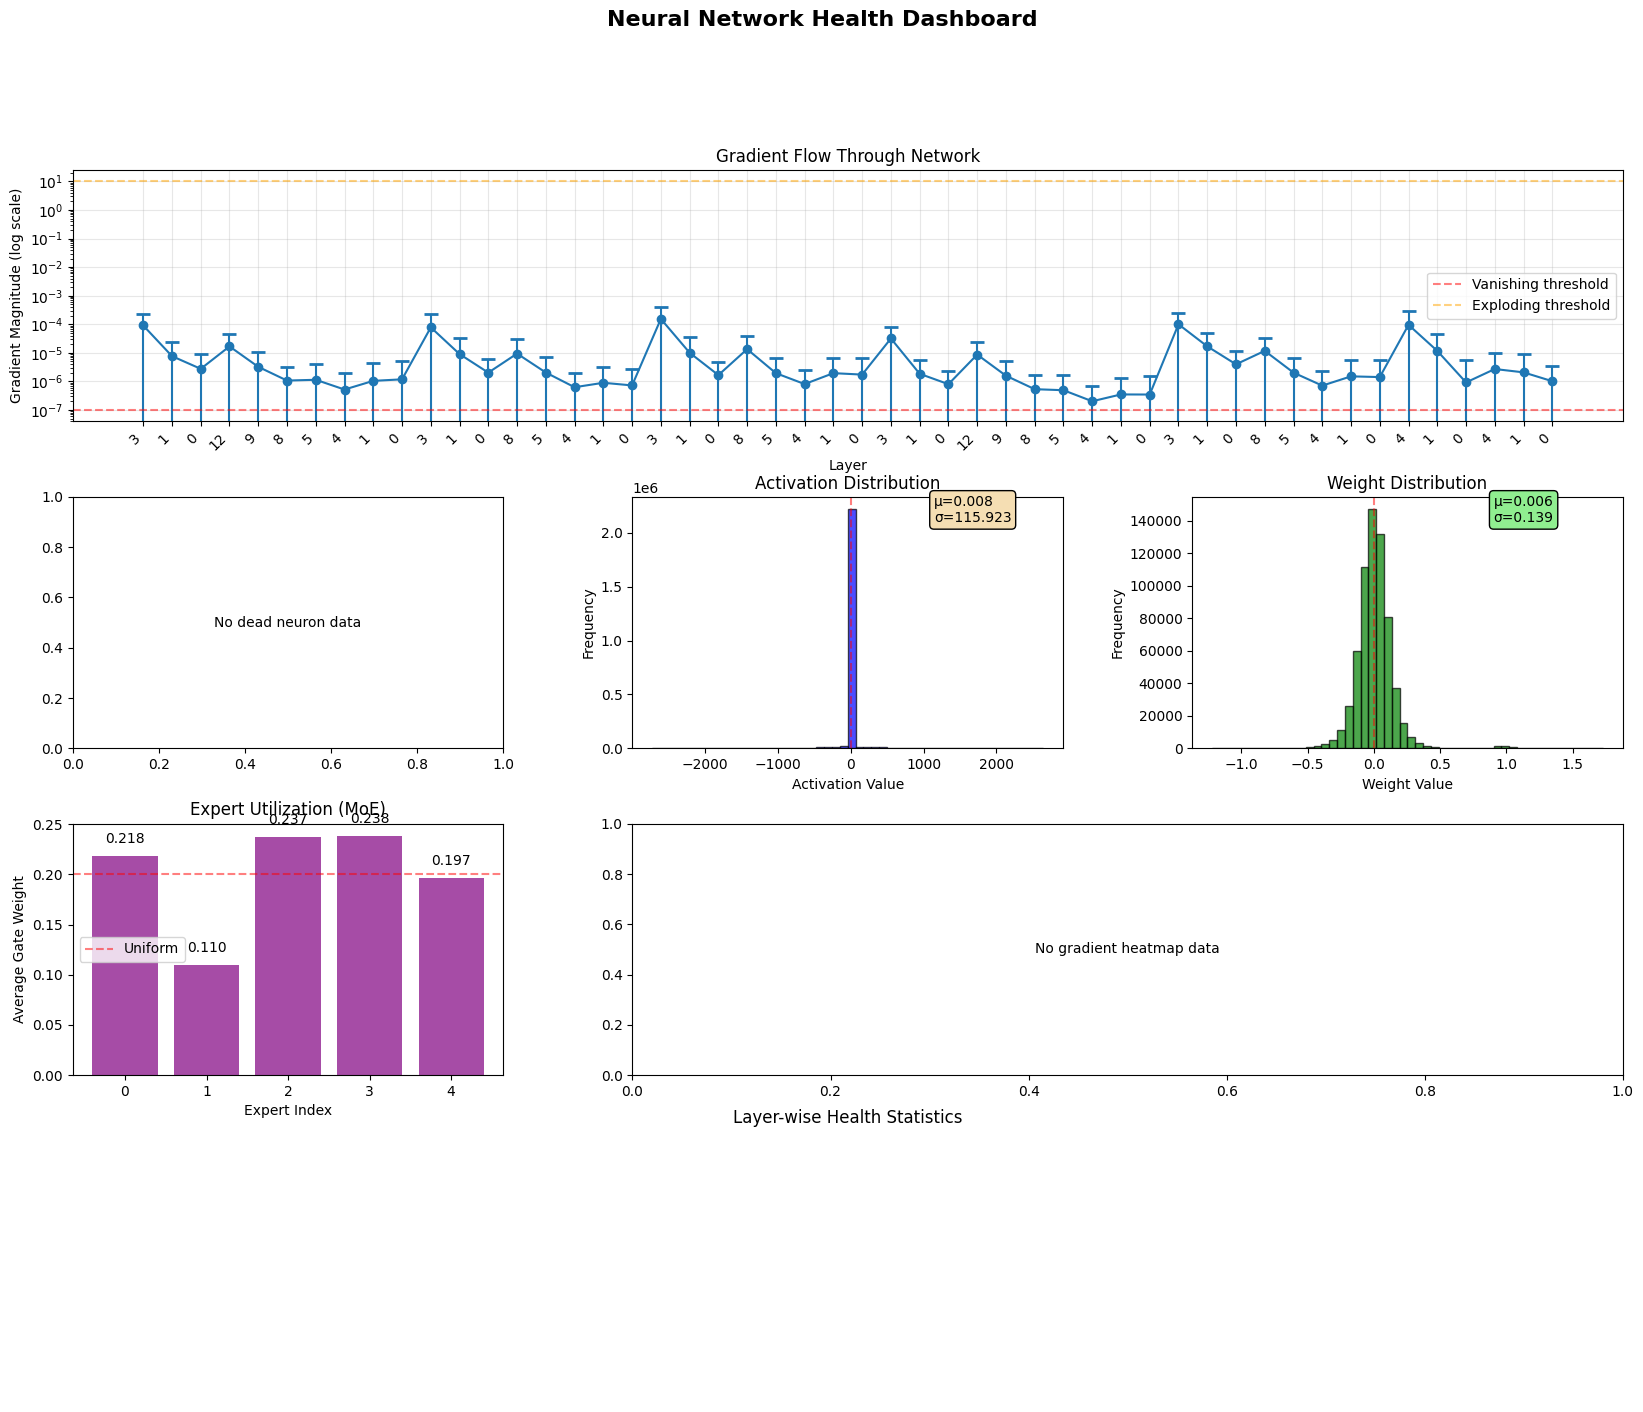


MODEL HEALTH REPORT

🔥 NaN/Inf DETECTION:
  ✅ No NaN/Inf detected

🔄 WEIGHT UPDATE HEALTH:
  ✅ All layers updating properly

📉 LOSS PROGRESS:
  Recent avg loss: 0.1111
  ✅ Loss improving (11.26% in last 10 batches)

🎯 EXPERT HEALTH (MoE):
  ✅ All experts active

📊 GRADIENT SCALE:
  ✅ Healthy gradient scaling (avg ratio: 0.26)

📈 GRADIENT HEALTH SUMMARY:
  - Layers with vanishing gradients: 7/50
  - Layers with exploding gradients: 0/50

OVERALL HEALTH SCORE
🟢 Health Score: 100/100 - GOOD


In [ ]:
monitor, losses = comprehensive_model_health_analysis(
    model=all_models_results['set2']['model'],
    dataloaders=all_models_results['set2']['dataloaders'],
    num_epochs=3,
    sample_batches_per_epoch=None
)